# Overview </br>
1. Introduction
2. Data Preparation 
3. Create Categorical Features with TF Feature Columns
4. Create Continuous/Numerical Features with TF Feature Columns
5. Build Deep Learning Regression Model with Sequential API and TF Probability Layers
6. Evaluating Potential Model Biases with Aequitas Toolkit

## 1. Introduction

As a data scientist, I have a groundbreaking diabetes drug that needs to conduct clinical trials to ensure its safety and efficacy. The drug requires administering it over at least 5-7 days of hospitalization with frequent monitoring and patient medication adherence training with a mobile application.

To identify suitable patients for our clinical trial, I will build a predictive regression model that can identify patients who are likely to require at least 5-7 days of hospitalization and would not incur significant additional costs for administering the diabetes drug. To achieve this, I will utilize a synthetic dataset based on the UCI Diabetes readmission dataset and focus on building the right data representation at the encounter level. I will also employ appropriate filtering and preprocessing/feature engineering techniques on key medical code sets to ensure unbiased model predictions across key demographic groups.

### Dataset

Due to healthcare PHI regulations (HIPAA, HITECH), there are limited number of publicly available datasets and some datasets require training and approval. So, for the purpose of this exercise, I am using a dataset from UC Irvine (https://archive.ics.uci.edu/ml/datasets/Diabetes+130-US+hospitals+for+years+1999-2008) that has been modified for this course. Please note that it is limited in its representation of some key features such as diagnosis codes which are usually an unordered list in 835s/837s (the HL7 standard interchange formats used for claims and remits).

Data Schema The dataset reference information can be https://github.com/udacity/nd320-c1-emr-data-starter/blob/master/project/data_schema_references/ . There are two CSVs that provide more details on the fields and some of the mapped values.

## 2. Data Preparation

In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
import tensorflow_probability as tfp
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import aequitas as ae
import random

In [2]:
import warnings
warnings.filterwarnings("ignore")

### Dataset Loading and Schema Review

Gaining a deeper understanding of the dataset. The dataset is located at the following path.

In [3]:
dataset_path = "./data/final_project_dataset.csv"
df = pd.read_csv(dataset_path)

In [4]:
df.head()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,number_emergency,num_lab_procedures,number_diagnoses,num_medications,num_procedures,ndc_code,max_glu_serum,A1Cresult,change,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,...,0,41,1,1,0,NaN,None,None,No,NO
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,...,0,59,9,18,0,68071-1701,None,None,Ch,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,...,0,11,6,13,5,0378-1110,None,None,No,NO
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,...,0,44,7,16,1,68071-1701,None,None,Ch,NO
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,...,0,51,5,8,0,0049-4110,None,None,Ch,NO


In [5]:
df.tail()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,number_emergency,num_lab_procedures,number_diagnoses,num_medications,num_procedures,ndc_code,max_glu_serum,A1Cresult,change,readmitted
143419,443854148,41088789,Caucasian,Male,[70-80),?,1,1,7,1,...,0,53,13,9,0,47918-902,None,None,Ch,NO
143420,443857166,31693671,Caucasian,Female,[80-90),?,2,3,7,10,...,0,45,9,21,2,0049-4110,None,None,Ch,NO
143421,443857166,31693671,Caucasian,Female,[80-90),?,2,3,7,10,...,0,45,9,21,2,0781-5421,None,None,Ch,NO
143422,443857166,31693671,Caucasian,Female,[80-90),?,2,3,7,10,...,0,45,9,21,2,47918-902,None,None,Ch,NO
143423,443867222,175429310,Caucasian,Male,[70-80),?,1,1,7,6,...,0,13,9,3,3,NaN,None,None,No,NO


__A lot of missing values are present in the dataset as '?'__

### Determine Level of Dataset (Line or Encounter)

To determine what level of aggregation is necessary for future steps

In [6]:
# Line Test
try:
    assert len(df) > df['encounter_id'].nunique() 
    print("Dataset could be at the line level")
except:
    print("Dataset is not at the line level")

Dataset could be at the line level


In [7]:
# Encounter Test
try:
    assert len(df) == df['encounter_id'].nunique()
    print("Dataset could be at the encounter level")
except:
    print("Dataset is not at the encounter level")

Dataset is not at the encounter level


__Dataset is at the line level__ i.e. each row in the dataset represents a single observation or encounter. Each encounter may have multiple attributes or features associated with it like include patient demographics, vital signs, lab results, medications, procedures, and other clinical information.

### Analyze Dataset

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 143424 entries, 0 to 143423
Data columns (total 26 columns):
 #   Column                    Non-Null Count   Dtype 
---  ------                    --------------   ----- 
 0   encounter_id              143424 non-null  int64 
 1   patient_nbr               143424 non-null  int64 
 2   race                      143424 non-null  object
 3   gender                    143424 non-null  object
 4   age                       143424 non-null  object
 5   weight                    143424 non-null  object
 6   admission_type_id         143424 non-null  int64 
 7   discharge_disposition_id  143424 non-null  int64 
 8   admission_source_id       143424 non-null  int64 
 9   time_in_hospital          143424 non-null  int64 
 10  payer_code                143424 non-null  object
 11  medical_specialty         143424 non-null  object
 12  primary_diagnosis_code    143424 non-null  object
 13  other_diagnosis_codes     143424 non-null  object
 14  numb

Column 'ndc_Code' has missing values

Checking Missing values

In [9]:
def missing_zero_values_table(df):
        mis_val = df.isnull().sum()
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        mz_table = pd.concat([mis_val, mis_val_percent], axis=1)
        mz_table = mz_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        mz_table['Data Type'] = df.dtypes
        mz_table = mz_table[
            mz_table.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns and " + str(df.shape[0]) + " Rows.\n"      
            "There are " + str(mz_table.shape[0]) +
              " columns that have missing values.")
        return mz_table

In [10]:
missing_zero_values_table(df)

Your selected dataframe has 26 columns and 143424 Rows.
There are 1 columns that have missing values.


,Missing Values,% of Total Values,Data Type
ndc_code,23462,16.4,object


Let's analyze the columns

In [11]:
df_cat_variables = ['race', 'gender', 'admission_type_id','discharge_disposition_id','admission_source_id','primary_diagnosis_code',
                 'other_diagnosis_codes', 'max_glu_serum','A1Cresult', 'change','ndc_code','medical_specialty','payer_code']

df_num_variables = ['time_in_hospital', 'number_outpatient', 'number_inpatient', 'number_emergency', 'num_lab_procedures',
                 'number_diagnoses', 'num_medications', 'num_procedures']

Not analyzing weight, medical_specialty, payer due to missing values - Present as '?'

Will check age column separately as it has bucketed data.

Numerical Features

In [12]:
import scipy.stats as stats
def check_outliers(df, variable):
    
    # define figure size
    plt.figure(figsize=(13, 5))

    # histogram
    plt.subplot(1, 3, 1)
    sns.histplot(df[variable], bins = 20)
    #sns.distplot(df[variable], bins=10)
    #plt.hist(df[variable], bins=10)
    plt.title('Histogram')
    #plt.title('Distplot')

    plt.subplot(1, 3, 2)
    stats.probplot(df[variable], dist="norm", plot=plt)
    plt.ylabel('Variable quantiles')

    # boxplot
    plt.subplot(1, 3, 3)
    sns.boxplot(y=df[variable])
    plt.title('Boxplot')

    plt.show()

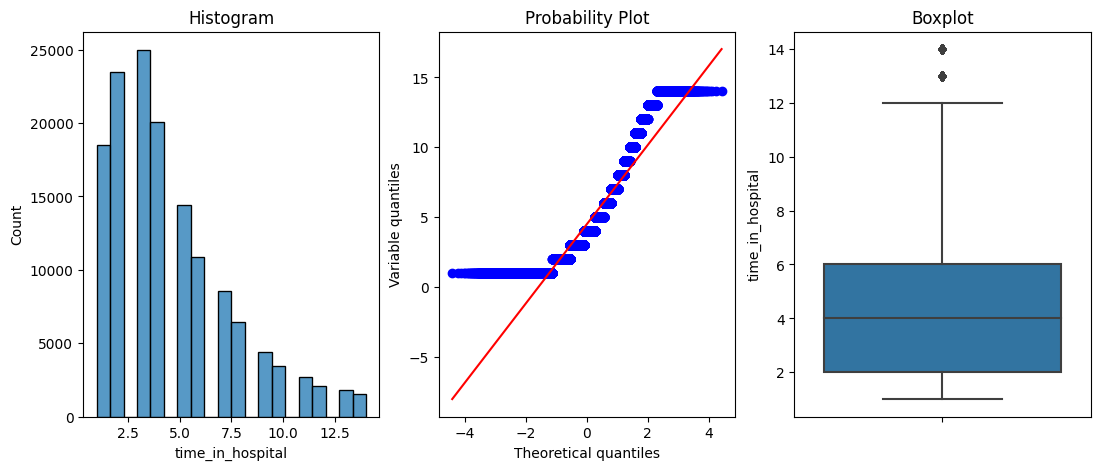

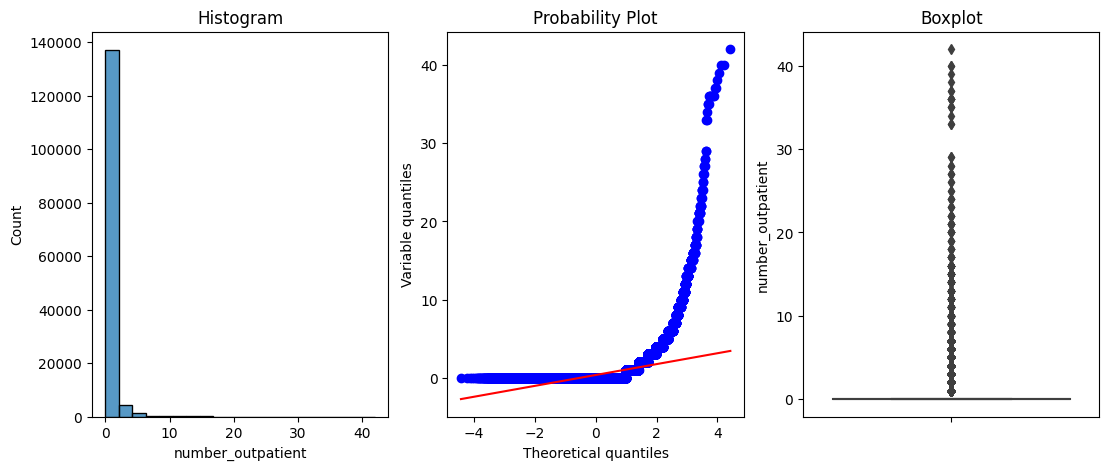

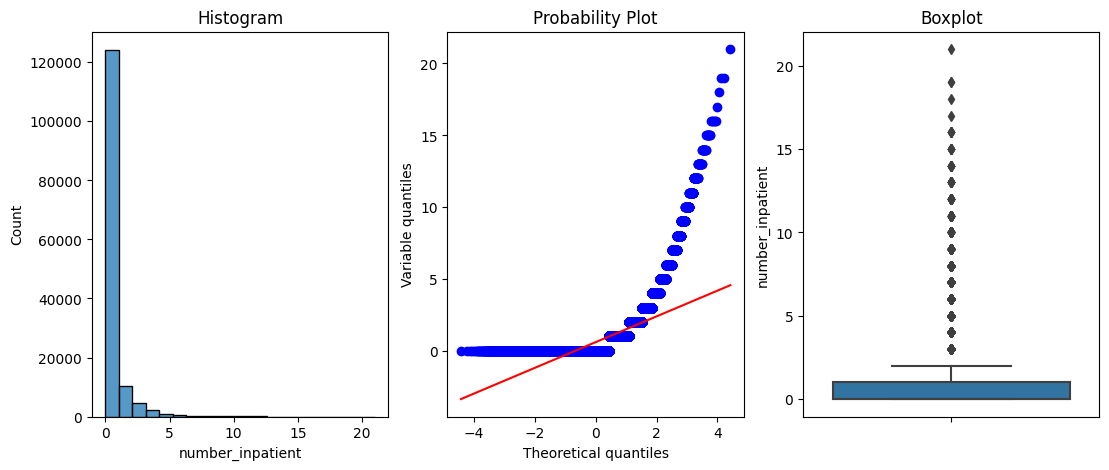

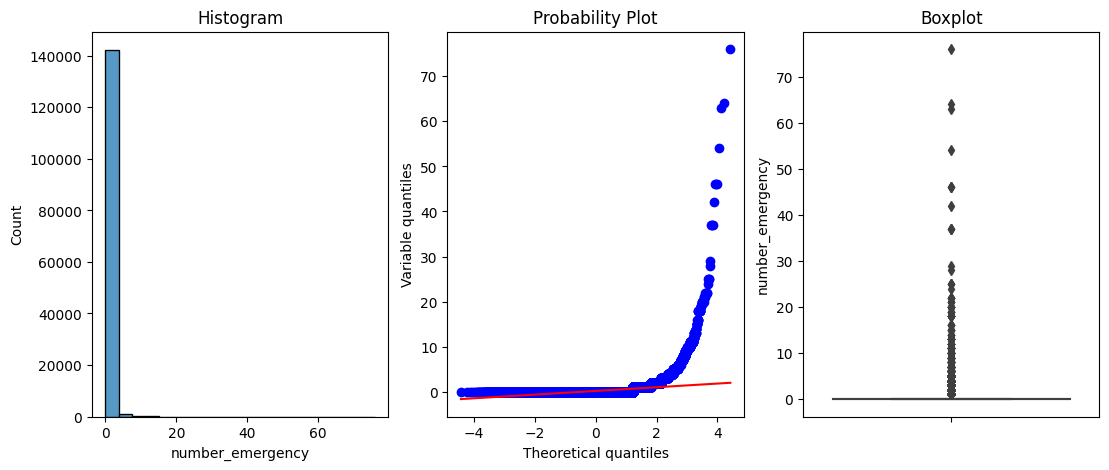

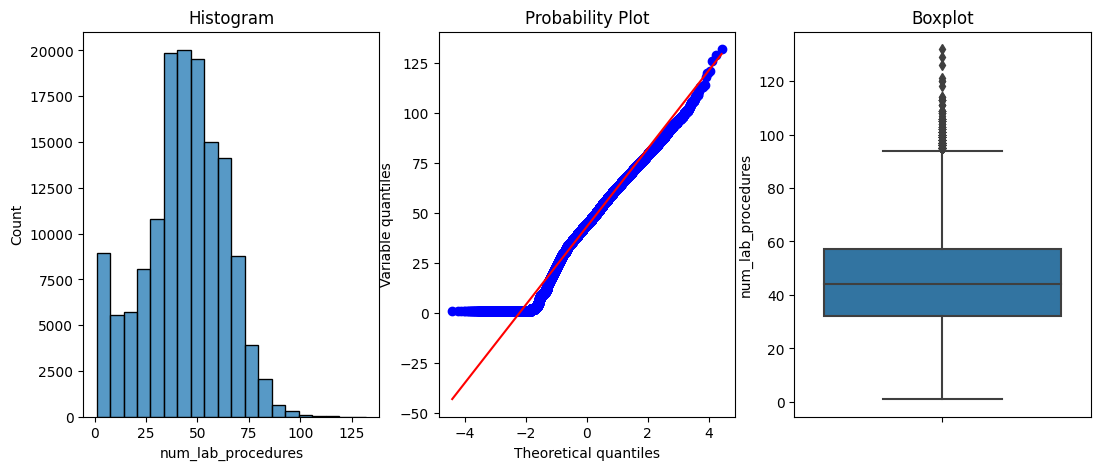

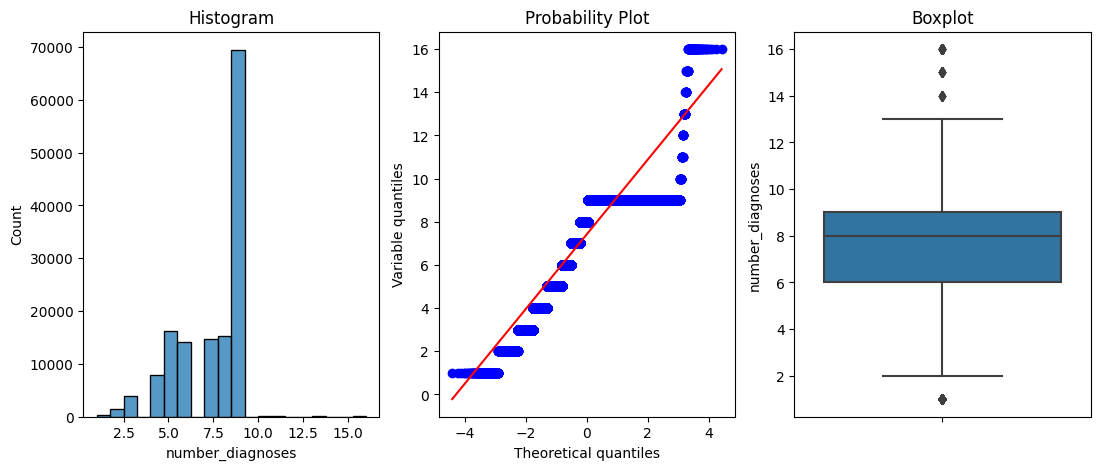

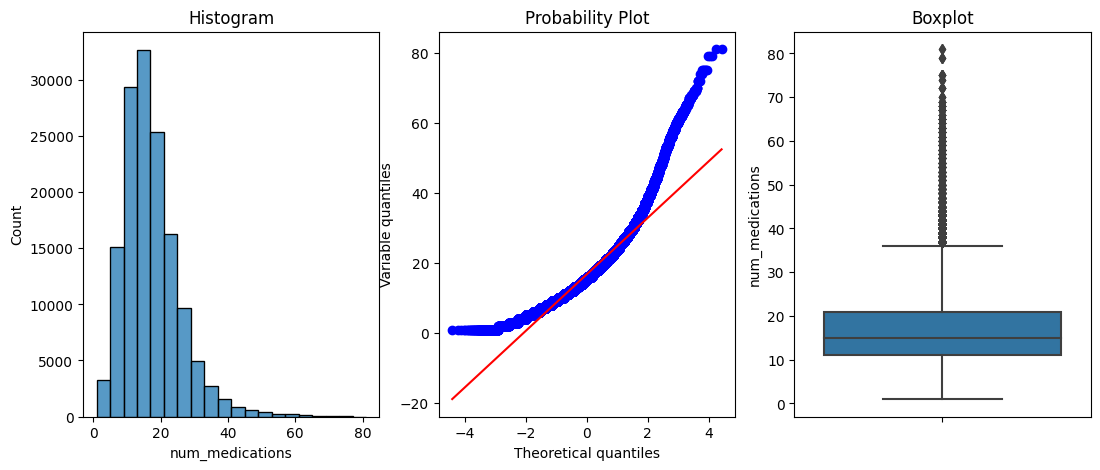

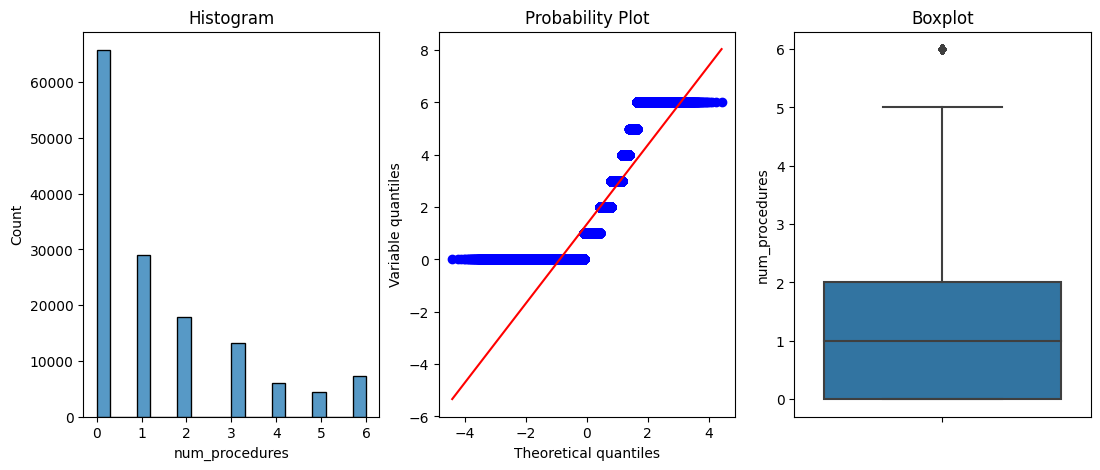

In [13]:
for col in df_num_variables:
    check_outliers(df, col)

Time in Hospital, num_procedures : Right Skewed Histogram. None Significant Outliers </br>
number_diagnoses: Left Skewed Histogram. None Significant Outliers </br>
</br>
</br>
The following columns have a significant number of outliers, most of which are pracatically not possible (error in recording): </br>
number_outpatient - Number of outpatient visits of the patient in the year preceding the encounter</br>
number_inpatient - Number of inpatient visits of the patient in the year preceding the encounter</br>
number_emergency - Number of emergency visits of the patient in the year preceding the encounter</br>
num_medications - Number of distinct generic names administered during the encounter</br>


Categorical Variables

In [14]:
# Checking Cardinality
for col in df_cat_variables:
    print('Column: ' + col)
    print('Number of unique elements (Cardinality): ' + str(df[col].nunique()))
    print()

Column: race
Number of unique elements (Cardinality): 6

Column: gender
Number of unique elements (Cardinality): 3

Column: admission_type_id
Number of unique elements (Cardinality): 8

Column: discharge_disposition_id
Number of unique elements (Cardinality): 26

Column: admission_source_id
Number of unique elements (Cardinality): 17

Column: primary_diagnosis_code
Number of unique elements (Cardinality): 717

Column: other_diagnosis_codes
Number of unique elements (Cardinality): 19374

Column: max_glu_serum
Number of unique elements (Cardinality): 4

Column: A1Cresult
Number of unique elements (Cardinality): 4

Column: change
Number of unique elements (Cardinality): 2

Column: ndc_code
Number of unique elements (Cardinality): 251

Column: medical_specialty
Number of unique elements (Cardinality): 73

Column: payer_code
Number of unique elements (Cardinality): 18



Columns 'primary_diagnosis_code', 'other_diagnosis_code'  have very high cardinality. </br>
These columns have primary and secondary diagnoses code (ICD9 - CM code set)

In [15]:
df[['primary_diagnosis_code','other_diagnosis_codes']].head(10)

,primary_diagnosis_code,other_diagnosis_codes
0,250.83,?|?
1,276,250.01|255
2,648,250|V27
3,8,250.43|403
4,197,157|250
5,197,157|250
6,414,411|250
7,414,411|V45
8,414,411|V45
9,414,411|V45


Column ndc_code also has high cardinality. This column includes NDC code(s) for drug prescribed during encounter. This variable is very important hence the dimenions should be reduced to be able to use for modeling.

#### Demographic Distributions

Text(0.5, 1.0, 'Histogram')

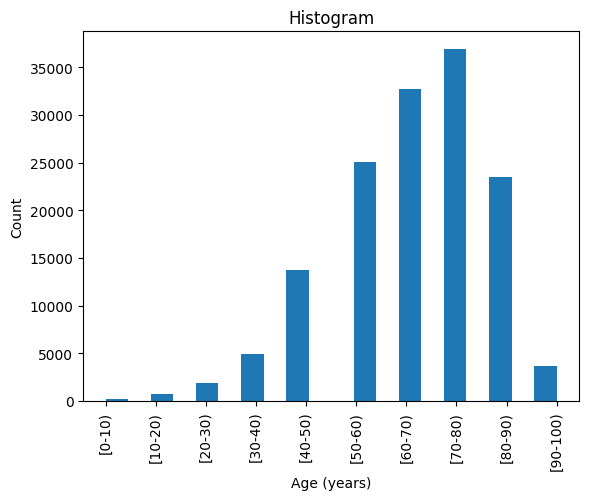

In [16]:
plt.hist(df['age'], bins = 20)
plt.xticks(rotation='vertical')
plt.xlabel('Age (years)')
plt.ylabel('Count')
plt.title('Histogram')

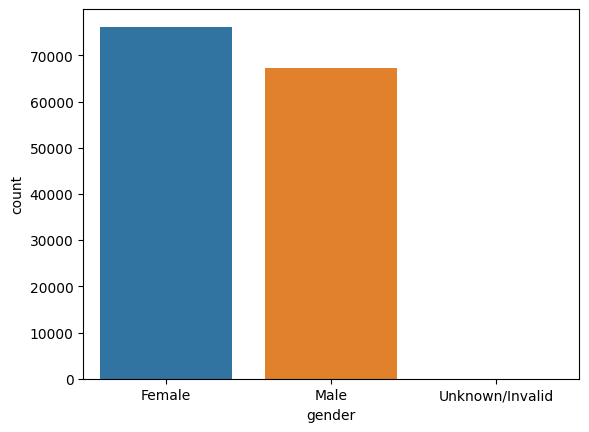

In [17]:
plt.figure()
ax = sns.countplot(x = 'gender', data = df)

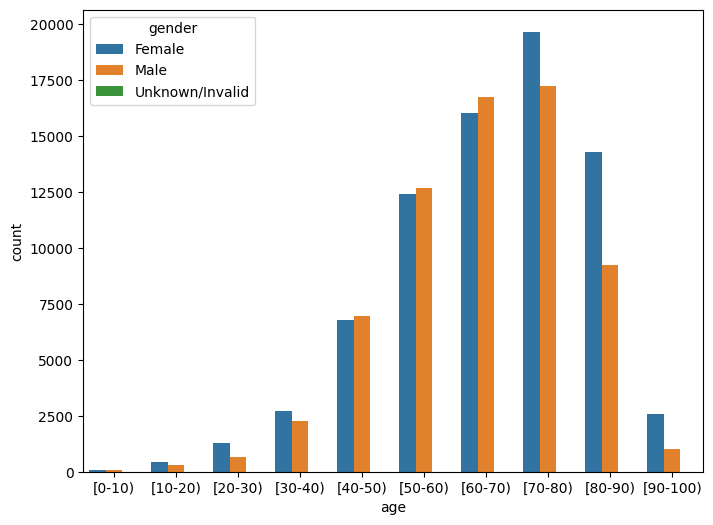

In [18]:
plt.figure(figsize=(8, 6))
ax = sns.countplot(x="age", hue="gender", data=df)

The number of females paitents is consistently higher in all the age groups, though the difference is not significant in the top 3 age-groups (in terms of number of patients).

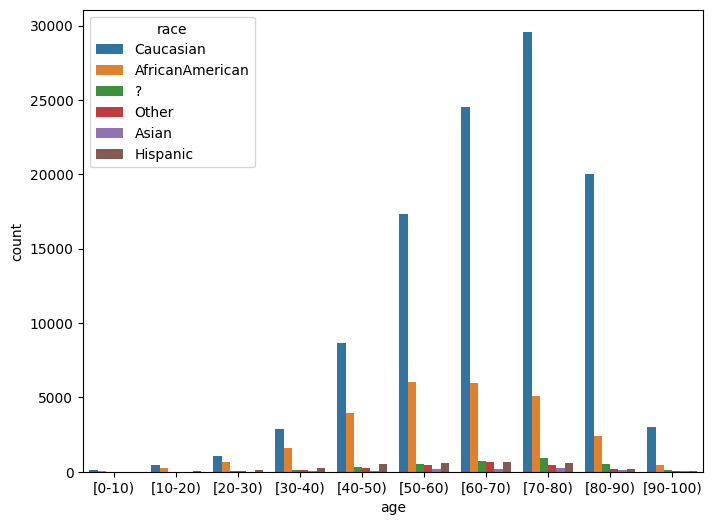

In [19]:
plt.figure(figsize=(8, 6))
ax = sns.countplot(x="age", hue="race", data=df)

Checking the female to male ratio.

In [20]:
len(df[df['gender'] == 'Female'])/len(df[df['gender'] == 'Male'])

1.1331320462861052

### Reduce Dimensionality of the NDC Code Feature

 NDC codes are a common format to represent the wide variety of drugs that are prescribed for patient care in the United States. The challenge is that there are many codes that map to the same or similar drug

In [21]:
#NDC code lookup file
ndc_code_path = "./data/final_ndc_lookup_table.txt"
ndc_code_df = pd.read_csv(ndc_code_path)

In [22]:
ndc_code_df.head()

,NDC_Code,Proprietary Name,Non-proprietary Name,Dosage Form,Route Name,Company Name,Product Type
0,0087-6060,Glucophage,Metformin Hydrochloride,"Tablet, Film Coated",Oral,Bristol-myers Squibb Company,Human Prescription Drug
1,0087-6063,Glucophage XR,Metformin Hydrochloride,"Tablet, Extended Release",Oral,Bristol-myers Squibb Company,Human Prescription Drug
2,0087-6064,Glucophage XR,Metformin Hydrochloride,"Tablet, Extended Release",Oral,Bristol-myers Squibb Company,Human Prescription Drug
3,0087-6070,Glucophage,Metformin Hydrochloride,"Tablet, Film Coated",Oral,Bristol-myers Squibb Company,Human Prescription Drug
4,0087-6071,Glucophage,Metformin Hydrochloride,"Tablet, Film Coated",Oral,Bristol-myers Squibb Company,Human Prescription Drug


In [23]:
df['ndc_code'].nunique()

251

To reduce the dimensions:  A lot of ndc_codes have a common non-propriety name. I will group the ndc_cols w.r.t non-propriety names to reduce the dimensionality and create a new column 'generic_drug_name'

In [24]:
from utils import reduce_dimension_ndc
reduce_dim_df = reduce_dimension_ndc(df,ndc_code_df)
reduce_dim_df = reduce_dim_df.drop('ndc_code', axis = 1)

In [25]:
# Number of unique values should be less for the new output field
assert df['ndc_code'].nunique() > reduce_dim_df['generic_drug_name'].nunique()

In [26]:
# New ndc_code values
reduce_dim_df['generic_drug_name'].unique()

array([nan, 'Insulin Human', 'Glipizide', 'Metformin Hcl', 'Glimepiride',
       'Glyburide', 'Rosiglitazone Maleate', 'Repaglinide', 'Acarbose',
       'Tolbutamide', 'Tolazamide', 'Pioglitazone',
       'Pioglitazone Hcl And Glimepiride', 'Glyburide And Metformin Hcl',
       'Nateglinide', 'Miglitol', 'Glipizide And Metformin Hcl',
       'Pioglitazone And Glimepiride', 'Pioglitazone And Metformin Hcl'],
      dtype=object)

In [27]:
reduce_dim_df['generic_drug_name'].value_counts()

Insulin Human                       54383
Metformin Hcl                       19988
Glipizide                           12686
Glyburide                           10650
Pioglitazone                         7328
Rosiglitazone Maleate                6365
Glimepiride                          5133
Repaglinide                          1539
Glyburide And Metformin Hcl           706
Nateglinide                           703
Acarbose                              308
Pioglitazone Hcl And Glimepiride       58
Tolazamide                             39
Miglitol                               38
Tolbutamide                            23
Glipizide And Metformin Hcl            13
Pioglitazone And Glimepiride            1
Pioglitazone And Metformin Hcl          1
Name: generic_drug_name, dtype: int64

### Select First Encounter for each Patient

So in many cases you may only want a snapshot of a patient's history for your modeling objective. In this case, I need to train the model on the initial condition of the patient i,e the first encounter of the patient so that I can predict the if the time of hospitalization is 5-7 days.

__Hence I will subset the data to have only the first encounter of each patient.__

In [28]:
from utils import select_first_encounter
first_encounter_df = select_first_encounter(reduce_dim_df)

In [29]:
# unique patients in transformed dataset
unique_patients = first_encounter_df['patient_nbr'].nunique()
print("Number of unique patients:{}".format(unique_patients))

# unique encounters in transformed dataset
unique_encounters = first_encounter_df['encounter_id'].nunique()
print("Number of unique encounters:{}".format(unique_encounters))

original_unique_patient_number = reduce_dim_df['patient_nbr'].nunique()
# number of unique patients should be equal to the number of unique encounters and patients in the final dataset
assert original_unique_patient_number == unique_patients
assert original_unique_patient_number == unique_encounters
print("Tests passed!!")

Number of unique patients:71518
Number of unique encounters:71518
Tests passed!!


### Aggregate Dataset to Right Level for Modeling

In [30]:
from utils import aggregate_dataset

exclusion_list = ['generic_drug_name']
grouping_field_list = [c for c in first_encounter_df.columns if c not in exclusion_list]

# agg_drug_df - aggregated dataframs
agg_drug_df, ndc_col_list = aggregate_dataset(first_encounter_df, grouping_field_list, 'generic_drug_name')

Since the generic drug names column is very important and has high cardinality. I have created dummy variable for each category. </br>
The ndc_col_list contains the column of all the ndc_col drugs

In [31]:
assert len(agg_drug_df) == agg_drug_df['patient_nbr'].nunique() == agg_drug_df['encounter_id'].nunique()

### Prepare Fields and Cast Dataset

#### Feature Selection

Now that I have the aggregated dataset, I will select the categorical and numerical features that you I use for the model, annd create a dataset subset.

In [32]:
agg_drug_df.head()

,patient_nbr,encounter_id,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,Insulin_Human,Metformin_Hcl,Miglitol,Nateglinide,Pioglitazone,Pioglitazone_Hcl_And_Glimepiride,Repaglinide,Rosiglitazone_Maleate,Tolazamide,Tolbutamide
0,135,24437208,Caucasian,Female,[50-60),?,2,1,1,8,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,378,29758806,Caucasian,Female,[50-60),?,3,1,1,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,729,189899286,Caucasian,Female,[80-90),?,1,3,7,4,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,774,64331490,Caucasian,Female,[80-90),?,1,1,7,3,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,927,14824206,AfricanAmerican,Female,[30-40),?,1,1,7,5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Addressing Missing Values

__As mentioned early in the analysis, the dataset has a lot of nan values disguised as "?"__

In [33]:
agg_drug_df = agg_drug_df.replace({'?': np.nan})

In [34]:
missing_zero_values_table(agg_drug_df)

Your selected dataframe has 42 columns and 71518 Rows.
There are 21 columns that have missing values.


,Missing Values,% of Total Values,Data Type
weight,68665,96.0,object
medical_specialty,34477,48.2,object
payer_code,31043,43.4,object
Glyburide_And_Metformin_Hcl,15385,21.5,float64
Metformin_Hcl,15385,21.5,float64
Tolazamide,15385,21.5,float64
Rosiglitazone_Maleate,15385,21.5,float64
Repaglinide,15385,21.5,float64
Pioglitazone_Hcl_And_Glimepiride,15385,21.5,float64
Pioglitazone,15385,21.5,float64


All the encoded variable from ndc_cde will have nan values.</br>


__The columns 'weight', 'medical_specialty', 'payer_code' have a very high percentage of missing values. Hence I will not use them for modeling.__

In [35]:
agg_drug_df.columns

Index(['patient_nbr', 'encounter_id', 'race', 'gender', 'age', 'weight',
       'admission_type_id', 'discharge_disposition_id', 'admission_source_id',
       'time_in_hospital', 'payer_code', 'medical_specialty',
       'primary_diagnosis_code', 'other_diagnosis_codes', 'number_outpatient',
       'number_inpatient', 'number_emergency', 'num_lab_procedures',
       'number_diagnoses', 'num_medications', 'num_procedures',
       'max_glu_serum', 'A1Cresult', 'change', 'readmitted',
       'generic_drug_name_array', 'Acarbose', 'Glimepiride', 'Glipizide',
       'Glipizide_And_Metformin_Hcl', 'Glyburide',
       'Glyburide_And_Metformin_Hcl', 'Insulin_Human', 'Metformin_Hcl',
       'Miglitol', 'Nateglinide', 'Pioglitazone',
       'Pioglitazone_Hcl_And_Glimepiride', 'Repaglinide',
       'Rosiglitazone_Maleate', 'Tolazamide', 'Tolbutamide'],
      dtype='object')

In [36]:
# list of vars
cat_variables = ['age','race', 'gender', 'admission_type_id','discharge_disposition_id','admission_source_id', 'readmitted',
       'primary_diagnosis_code','other_diagnosis_codes', 'max_glu_serum','A1Cresult', 'change','medical_specialty','payer_code']

num_variables = ['weight','time_in_hospital', 'number_outpatient',
       'number_inpatient', 'number_emergency', 'num_lab_procedures',
       'number_diagnoses', 'num_medications', 'num_procedures']

Selecting Categorical Features

In [37]:
# Rechecking cardinality
for col in cat_variables:
    print('Column: ' + col)
    print('Number of unique elements (Cardinality): ' + str(agg_drug_df[col].nunique()))

Column: age
Number of unique elements (Cardinality): 10
Column: race
Number of unique elements (Cardinality): 5
Column: gender
Number of unique elements (Cardinality): 3
Column: admission_type_id
Number of unique elements (Cardinality): 8
Column: discharge_disposition_id
Number of unique elements (Cardinality): 26
Column: admission_source_id
Number of unique elements (Cardinality): 17
Column: readmitted
Number of unique elements (Cardinality): 3
Column: primary_diagnosis_code
Number of unique elements (Cardinality): 696
Column: other_diagnosis_codes
Number of unique elements (Cardinality): 15756
Column: max_glu_serum
Number of unique elements (Cardinality): 4
Column: A1Cresult
Number of unique elements (Cardinality): 4
Column: change
Number of unique elements (Cardinality): 2
Column: medical_specialty
Number of unique elements (Cardinality): 70
Column: payer_code
Number of unique elements (Cardinality): 17


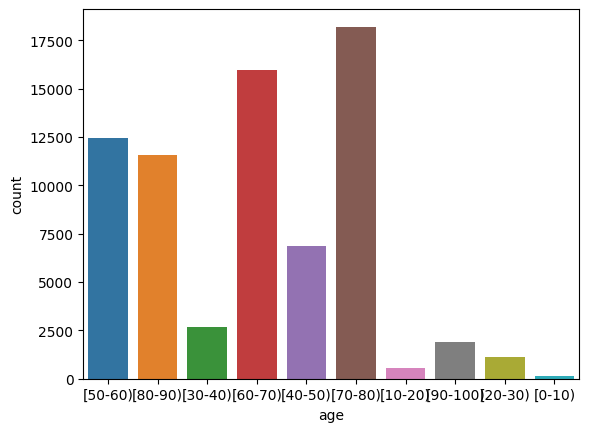

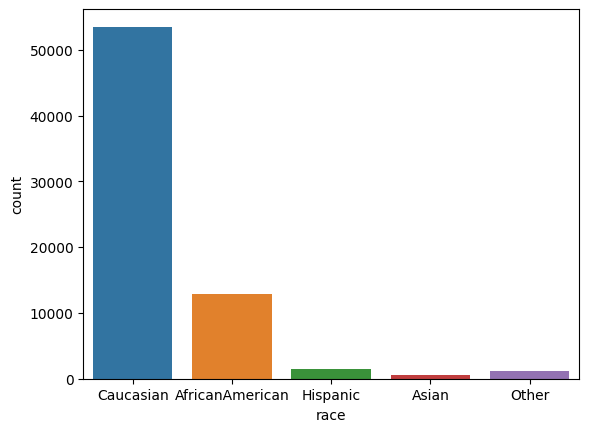

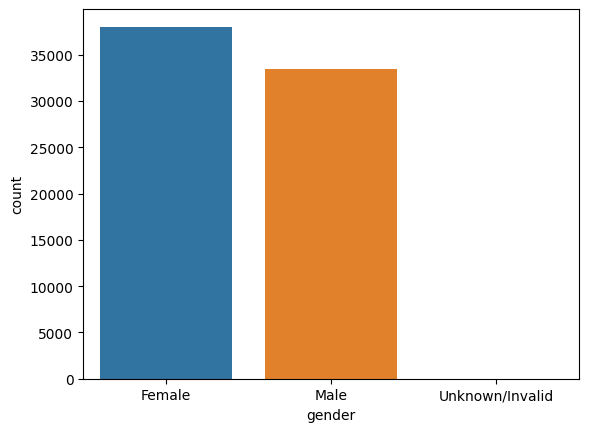

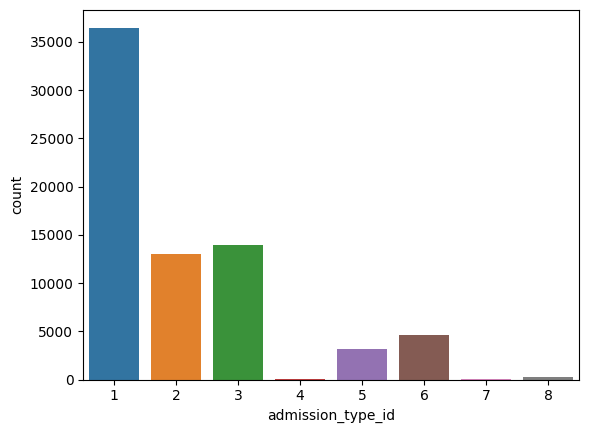

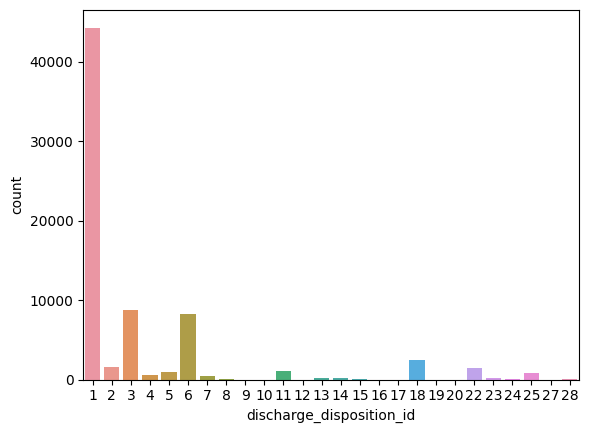

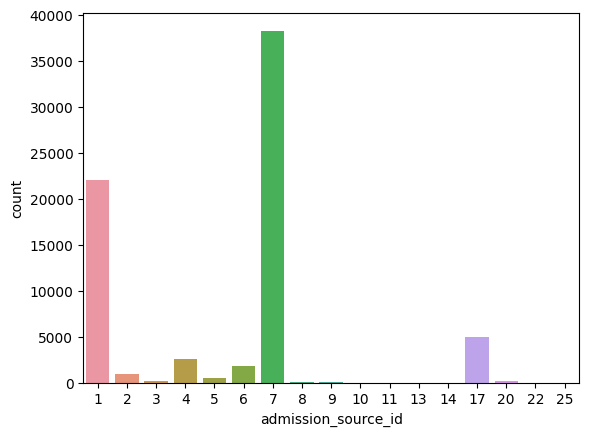

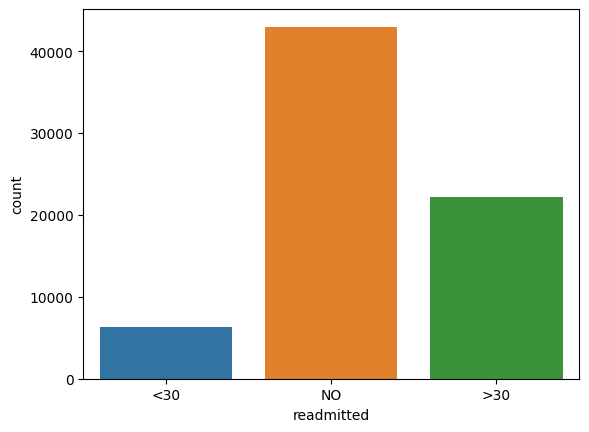

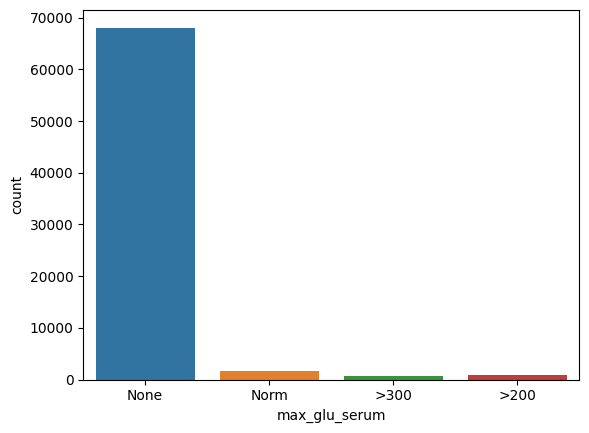

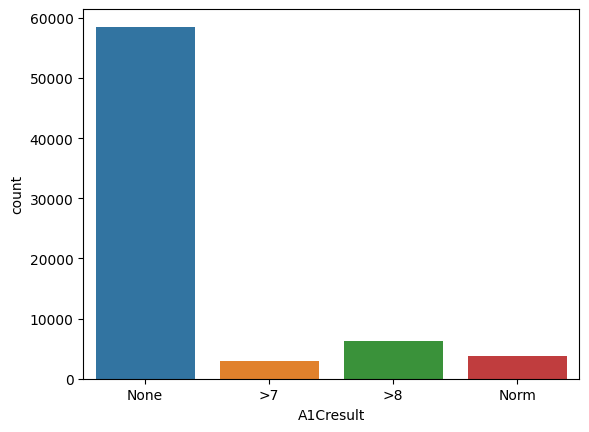

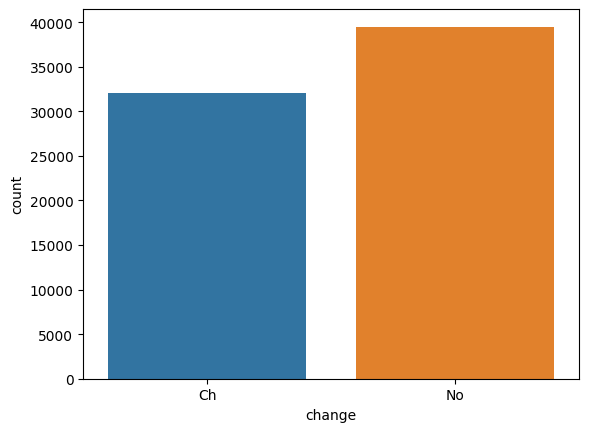

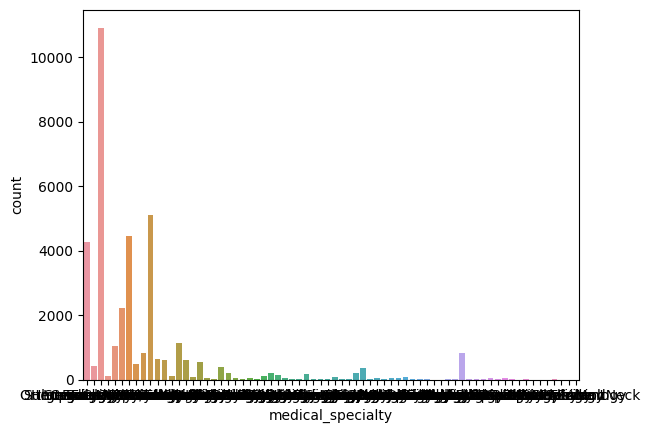

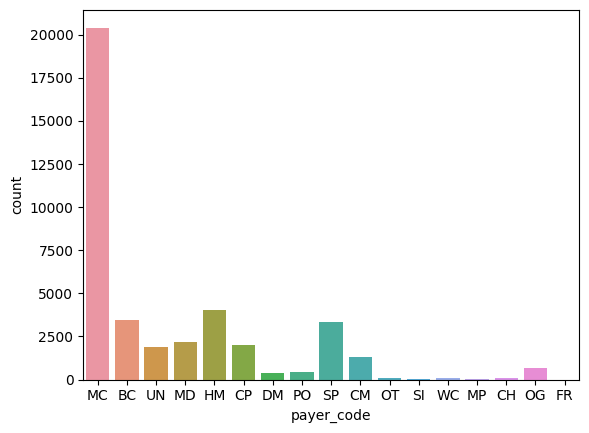

In [38]:
plt.style.use('default')
import warnings
warnings.filterwarnings('ignore')

for col in filter(lambda col: col not in ['primary_diagnosis_code','other_diagnosis_codes'],cat_variables):
    plt.figure()
    ax = sns.countplot(x = col, data = agg_drug_df)

__Most of the values in the columns 'max_glu_serum', 'A1Cresult' are "None". This will not add significant value to the model.__

__The following column are highly imbalanced and will not be used for modeling: 'discharge_disposition_id', 'admission_source_id', 'admission_type_id', 'admission_disposition_id'.__

__Selected column - age, race, gender, change, readmitted, primary_diagnosis_code__

In [39]:
agg_drug_df[num_variables].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 71518 entries, 0 to 71517
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   weight              2853 non-null   object
 1   time_in_hospital    71518 non-null  int64 
 2   number_outpatient   71518 non-null  int64 
 3   number_inpatient    71518 non-null  int64 
 4   number_emergency    71518 non-null  int64 
 5   num_lab_procedures  71518 non-null  int64 
 6   number_diagnoses    71518 non-null  int64 
 7   num_medications     71518 non-null  int64 
 8   num_procedures      71518 non-null  int64 
dtypes: int64(8), object(1)
memory usage: 7.5+ MB


Selecting Numerical Fetures

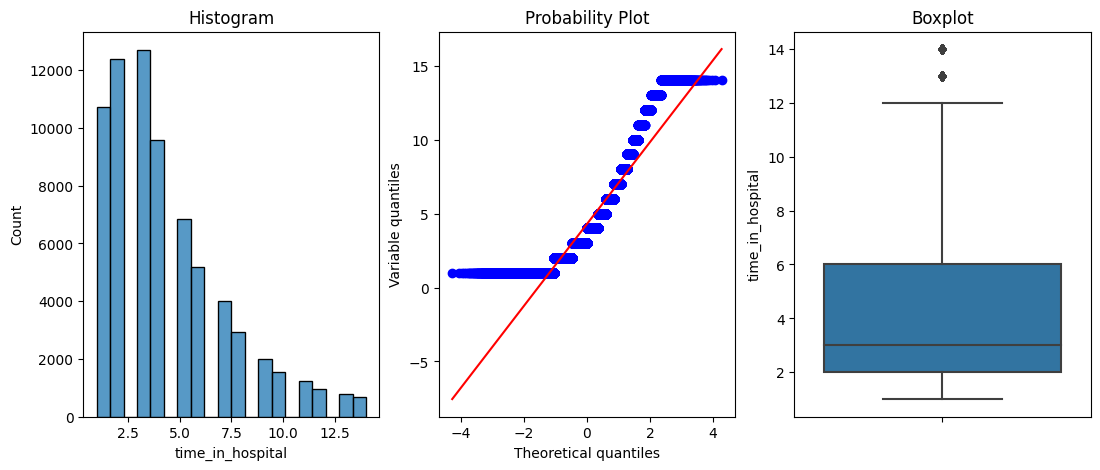

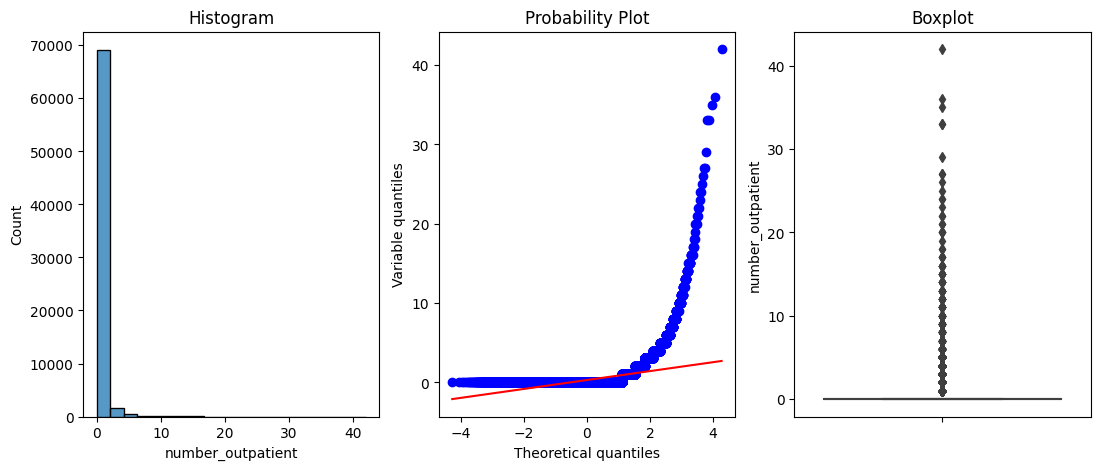

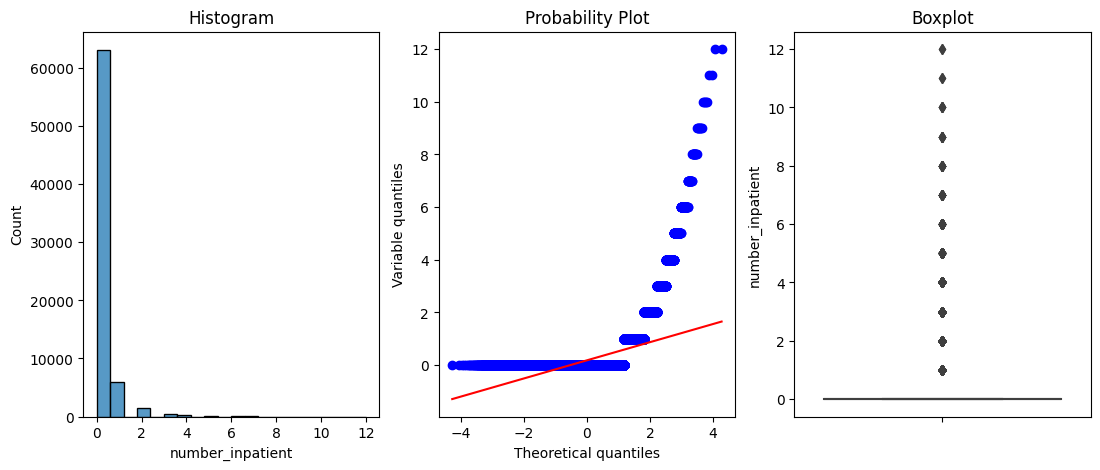

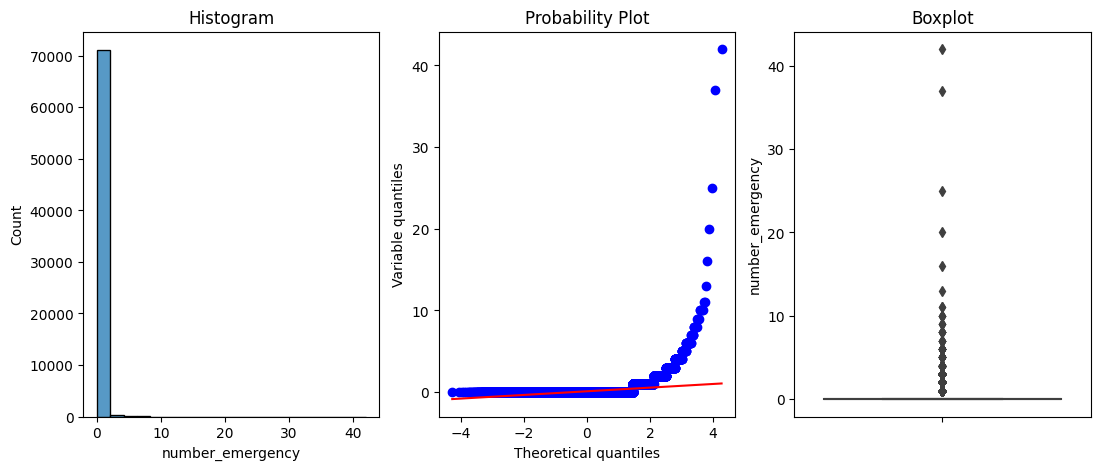

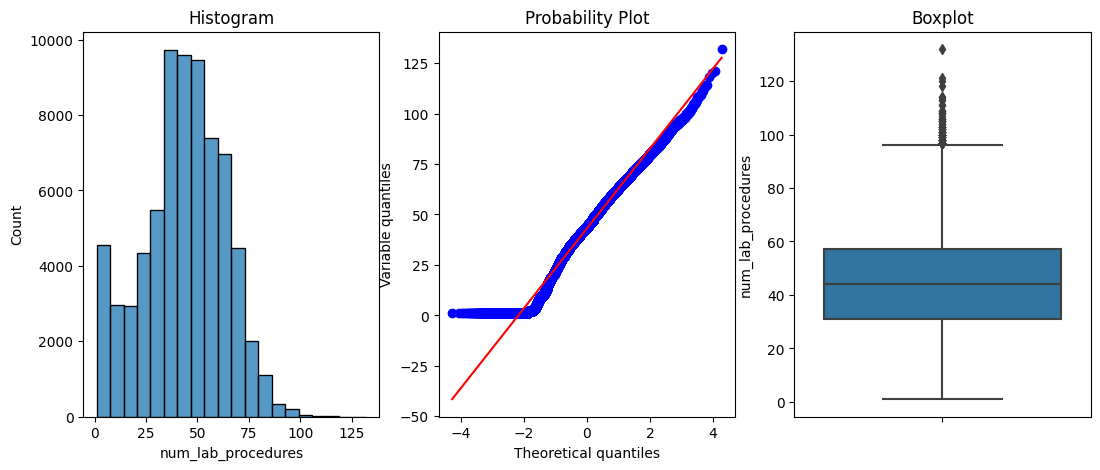

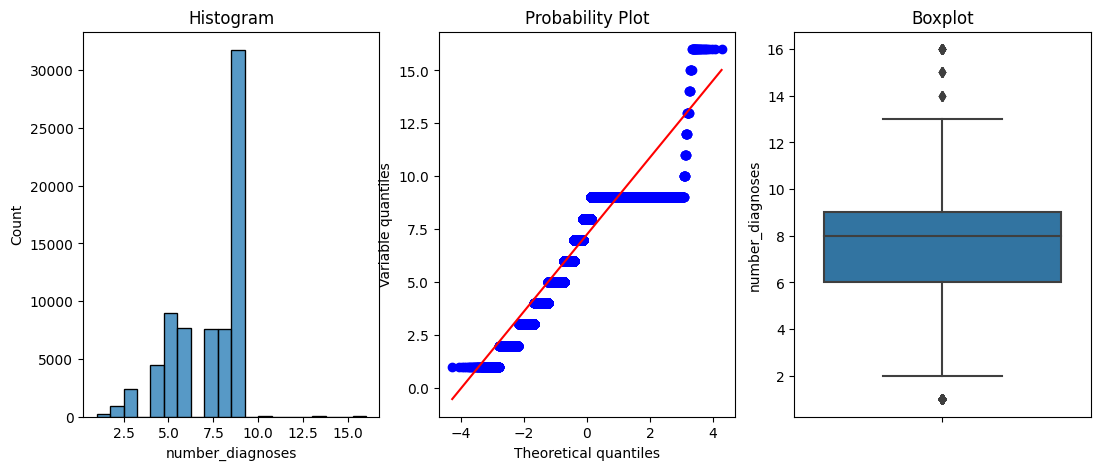

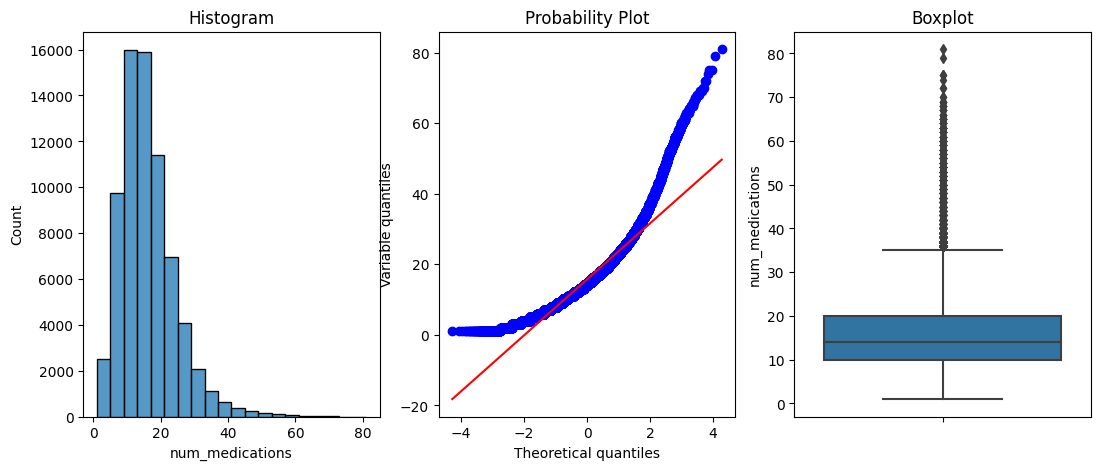

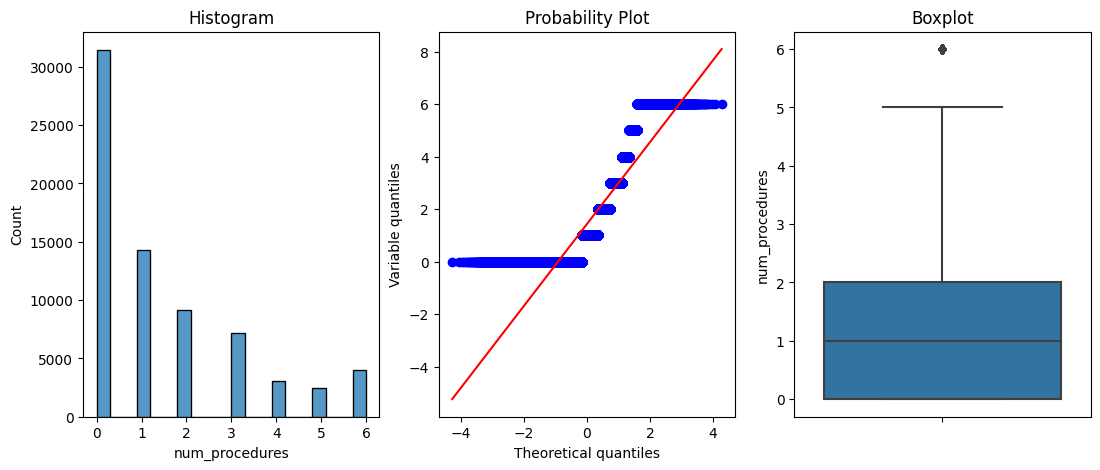

In [40]:
for col in ['time_in_hospital', 'number_outpatient', 'number_inpatient', 'number_emergency', 'num_lab_procedures', 'number_diagnoses', 'num_medications', 'num_procedures']:
    check_outliers(agg_drug_df, col)

__Selected column - 'num_lab_procedures','num_medications','num_procedures','number_diagnoses'__ </br>

__'time_in_hospital' - predict column__

In [41]:
# Final Variables
final_cat_vars = ['race', 'gender', 'age', 'change','readmitted','primary_diagnosis_code'] + ndc_col_list
final_nums_vars = ['num_lab_procedures','num_medications','num_procedures','number_diagnoses']
predict_var = 'time_in_hospital'

Creating Subset for Modeling

In [42]:
def select_model_features(df, categorical_col_list, numerical_col_list, PREDICTOR_FIELD, grouping_key='patient_nbr'):
    selected_col_list = [grouping_key] + [PREDICTOR_FIELD] + categorical_col_list + numerical_col_list   
    return agg_drug_df[selected_col_list]

In [43]:
selected_features_df = select_model_features(agg_drug_df, final_cat_vars, final_nums_vars, predict_var)

In [44]:
selected_features_df.head()

,patient_nbr,time_in_hospital,race,gender,age,change,readmitted,primary_diagnosis_code,Acarbose,Glimepiride,...,Pioglitazone,Pioglitazone_Hcl_And_Glimepiride,Repaglinide,Rosiglitazone_Maleate,Tolazamide,Tolbutamide,num_lab_procedures,num_medications,num_procedures,number_diagnoses
0,135,8,Caucasian,Female,[50-60),Ch,<30,401,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,77,33,6,8
1,378,2,Caucasian,Female,[50-60),No,NO,722,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,49,11,1,3
2,729,4,Caucasian,Female,[80-90),No,NO,820,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,68,23,2,9
3,774,3,Caucasian,Female,[80-90),Ch,NO,274,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,46,20,0,9
4,927,5,AfricanAmerican,Female,[30-40),No,NO,590,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,49,5,0,3


#### Preprocess Dataset - Casting and Imputing

I will cast and impute the dataset before splitting so that I do not have to repeat these steps across the dataset splits required for modelling.

In [45]:
selected_features_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 71518 entries, 0 to 71517
Data columns (total 28 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   patient_nbr                       71518 non-null  int64  
 1   time_in_hospital                  71518 non-null  int64  
 2   race                              69570 non-null  object 
 3   gender                            71518 non-null  object 
 4   age                               71518 non-null  object 
 5   change                            71518 non-null  object 
 6   readmitted                        71518 non-null  object 
 7   primary_diagnosis_code            71507 non-null  object 
 8   Acarbose                          56133 non-null  float64
 9   Glimepiride                       56133 non-null  float64
 10  Glipizide                         56133 non-null  float64
 11  Glipizide_And_Metformin_Hcl       56133 non-null  float64
 12  Glyb

In [46]:
selected_features_df[final_nums_vars].isna().sum()

num_lab_procedures    0
num_medications       0
num_procedures        0
number_diagnoses      0
dtype: int64

In [47]:
selected_features_df[final_cat_vars].isna().sum()

race                                 1948
gender                                  0
age                                     0
change                                  0
readmitted                              0
primary_diagnosis_code                 11
Acarbose                            15385
Glimepiride                         15385
Glipizide                           15385
Glipizide_And_Metformin_Hcl         15385
Glyburide                           15385
Glyburide_And_Metformin_Hcl         15385
Insulin_Human                       15385
Metformin_Hcl                       15385
Miglitol                            15385
Nateglinide                         15385
Pioglitazone                        15385
Pioglitazone_Hcl_And_Glimepiride    15385
Repaglinide                         15385
Rosiglitazone_Maleate               15385
Tolazamide                          15385
Tolbutamide                         15385
dtype: int64

In [48]:
selected_features_df.dropna(axis=0 , how="any",subset=['race','primary_diagnosis_code'] , inplace= True)


In [49]:
# Imputing categorical values with 'nan'
from utils import preprocess_df
processed_df = preprocess_df(selected_features_df, final_cat_vars, final_nums_vars, predict_var, categorical_impute_value='nan')

In [50]:
processed_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 69560 entries, 0 to 71517
Data columns (total 28 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   patient_nbr                       69560 non-null  int64  
 1   time_in_hospital                  69560 non-null  float64
 2   race                              69560 non-null  object 
 3   gender                            69560 non-null  object 
 4   age                               69560 non-null  object 
 5   change                            69560 non-null  object 
 6   readmitted                        69560 non-null  object 
 7   primary_diagnosis_code            69560 non-null  object 
 8   Acarbose                          69560 non-null  object 
 9   Glimepiride                       69560 non-null  object 
 10  Glipizide                         69560 non-null  object 
 11  Glipizide_And_Metformin_Hcl       69560 non-null  object 
 12  Glyb

### Split Dataset into Train, Validation, and Test Partitions

 In order to prepare the data for being trained and evaluated by a deep learning model, I will split the dataset into three partitions, with the validation partition used for optimizing the model hyperparameters during training.

In [51]:
processed_df['patient_nbr'].nunique()

69560

In [52]:
processed_df.columns

Index(['patient_nbr', 'time_in_hospital', 'race', 'gender', 'age', 'change',
       'readmitted', 'primary_diagnosis_code', 'Acarbose', 'Glimepiride',
       'Glipizide', 'Glipizide_And_Metformin_Hcl', 'Glyburide',
       'Glyburide_And_Metformin_Hcl', 'Insulin_Human', 'Metformin_Hcl',
       'Miglitol', 'Nateglinide', 'Pioglitazone',
       'Pioglitazone_Hcl_And_Glimepiride', 'Repaglinide',
       'Rosiglitazone_Maleate', 'Tolazamide', 'Tolbutamide',
       'num_lab_procedures', 'num_medications', 'num_procedures',
       'number_diagnoses'],
      dtype='object')

In [53]:
df1 = processed_df

In [54]:
pwd

'c:\\Users\\kambl\\Dropbox\\PC\\Desktop\\Hrishikesh\\Job\\Udacity_Health\\EHR_Diabetes\\Project'

Splitting Data into Train, Validation and Test set

In [55]:
from utils import patient_dataset_splitter
d_train, d_val, d_test = patient_dataset_splitter(df1, 'patient_nbr')

Total number of unique patients in train =  41736
Total number of unique patients in validation =  13912
Total number of unique patients in test =  13912
Training partition has a shape =  (41736, 28)
Validation partition has a shape =  (13912, 28)
Test partition has a shape =  (13912, 28)


 One of the key parts is to make sure that the data does not accidently leak across partitions.

Verify Total number of rows in original dataset = sum of rows across all three dataset partitions

In [56]:
assert len(d_train) + len(d_val) + len(d_test) == len(processed_df)
print("Test passed for number of total rows equal!")


Test passed for number of total rows equal!


Verify that the total number of unique patients across the splits is equal to the total number of unique patients in the original dataset

In [57]:
assert (d_train['patient_nbr'].nunique() + d_val['patient_nbr'].nunique() + d_test['patient_nbr'].nunique()) == selected_features_df['patient_nbr'].nunique()
print("Test passed for number of unique patients being equal!")

Test passed for number of unique patients being equal!


### Demographic Representation Analysis of Split

After the split, visualize the distribution of key features/groups and make sure that there is representative samples across the partitions.

#### Label Distribution Across Partitions

Verifying that the distribution of our predictor varible is similar in the train/test datasets to that of the processed_df

AxesSubplot(0.125,0.11;0.227941x0.77)
AxesSubplot(0.398529,0.11;0.227941x0.77)
AxesSubplot(0.672059,0.11;0.227941x0.77)


Text(0.5, 0, 'Test Dataset')

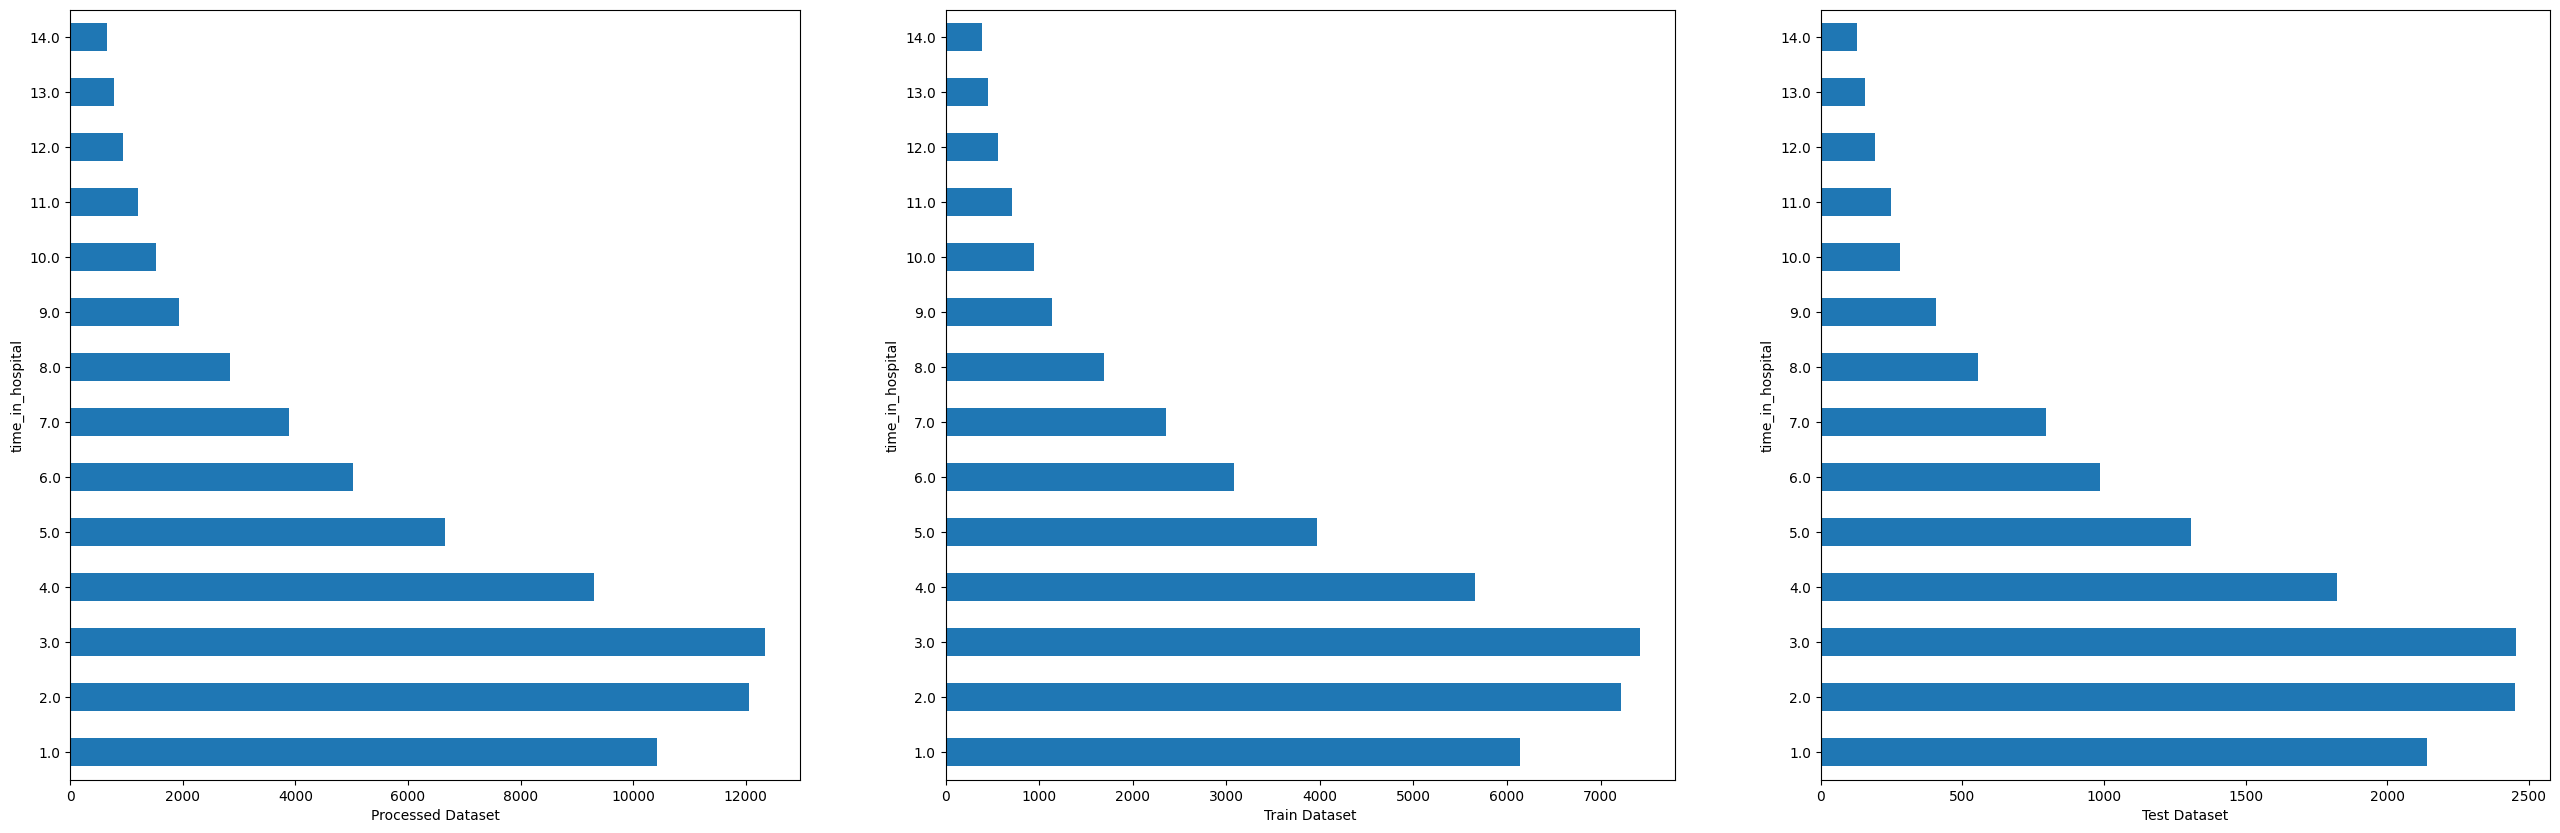

In [58]:
from utils import show_group_stats_viz
plt.figure(figsize=[32,10])
plt.subplot(1,3,1)
show_group_stats_viz(processed_df, predict_var)
plt.xlabel('Processed Dataset')
plt.subplot(1,3,2)
show_group_stats_viz(d_train, predict_var)
plt.xlabel('Train Dataset')
plt.subplot(1,3,3)
show_group_stats_viz(d_test, predict_var)
plt.xlabel('Test Dataset')

Train dataset time_in_hospital distribution is similar to processsed_df's distribution

Test dataset time_in_hospital distribution is similar to processed_df's distribution

#### Demographic Group Analysis

We should check that our partitions/splits of the dataset are similar in terms of their demographic profiles.

In [59]:
# Full dataset before splitting
patient_demo_features = ['race', 'gender', 'age', 'patient_nbr']
patient_group_analysis_df = processed_df[patient_demo_features]

AxesSubplot(0.125,0.11;0.227941x0.77)
AxesSubplot(0.398529,0.11;0.227941x0.77)
AxesSubplot(0.672059,0.11;0.227941x0.77)
AxesSubplot(0.125,0.11;0.227941x0.77)
AxesSubplot(0.398529,0.11;0.227941x0.77)
AxesSubplot(0.672059,0.11;0.227941x0.77)
AxesSubplot(0.125,0.11;0.227941x0.77)
AxesSubplot(0.398529,0.11;0.227941x0.77)
AxesSubplot(0.672059,0.11;0.227941x0.77)


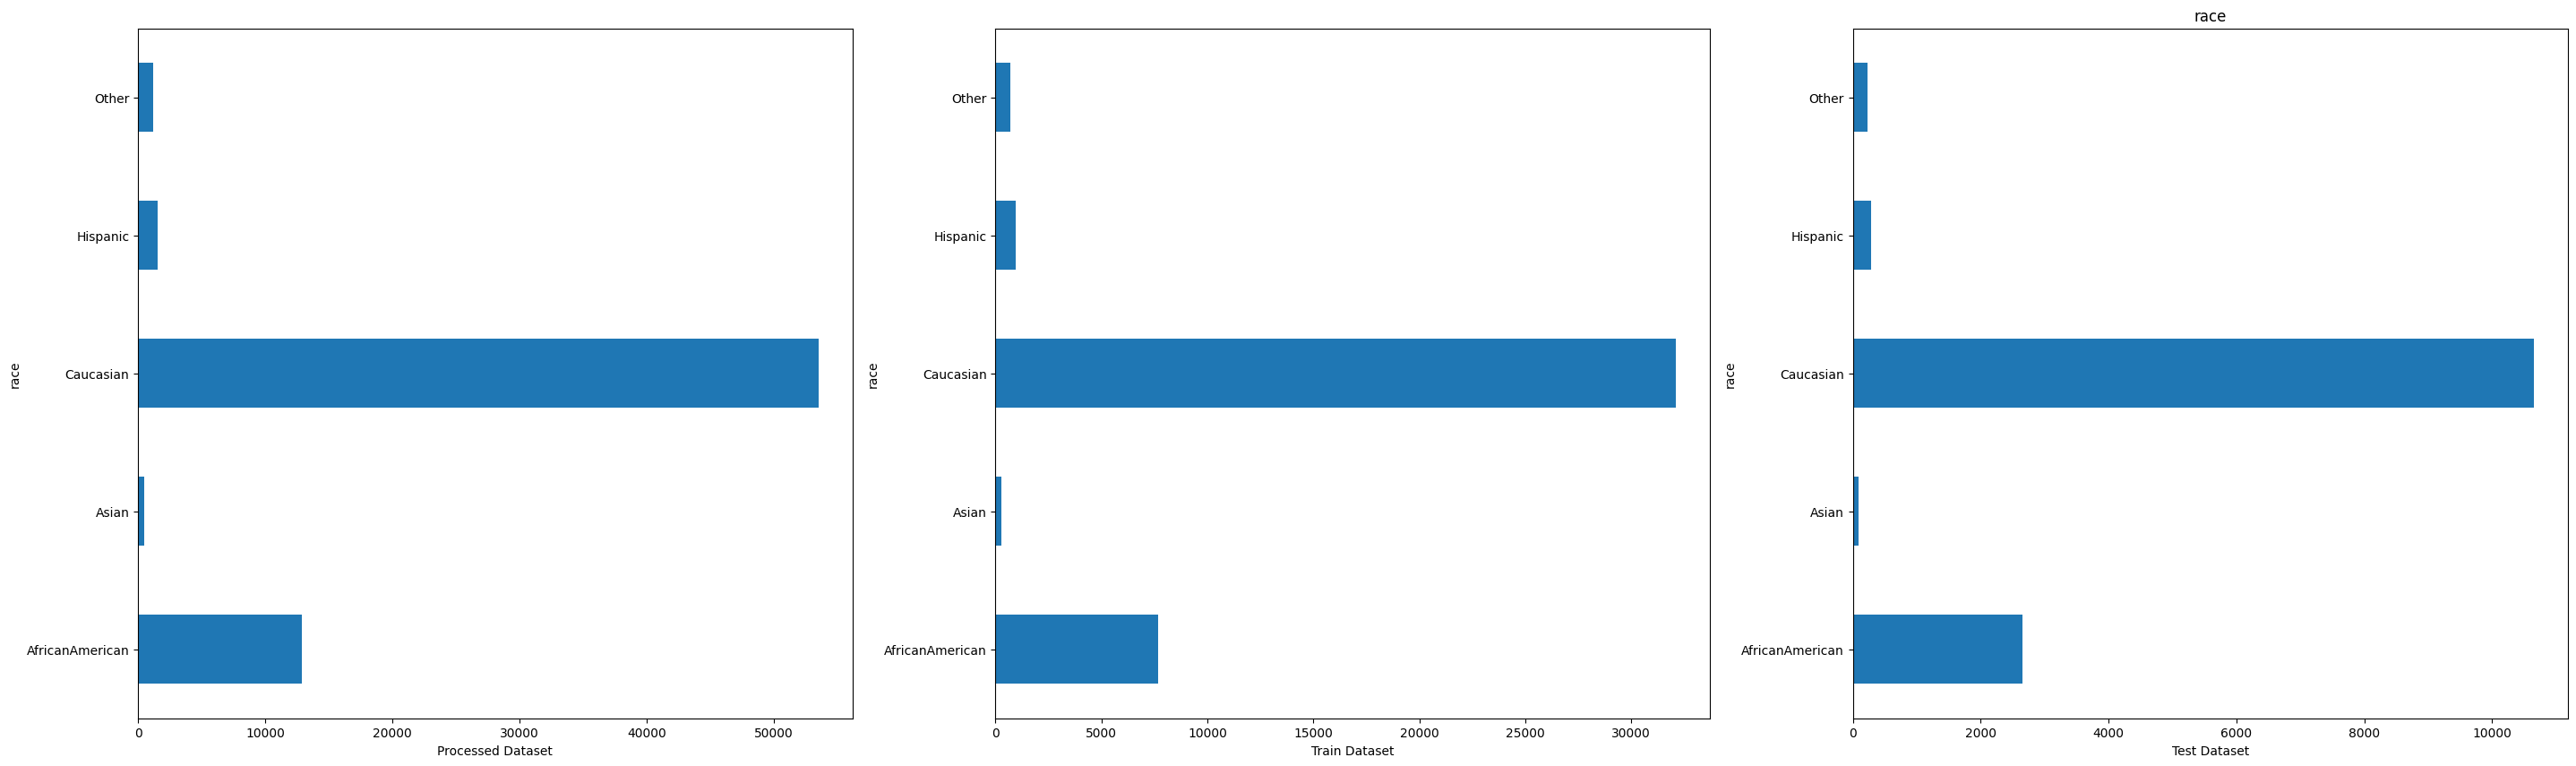

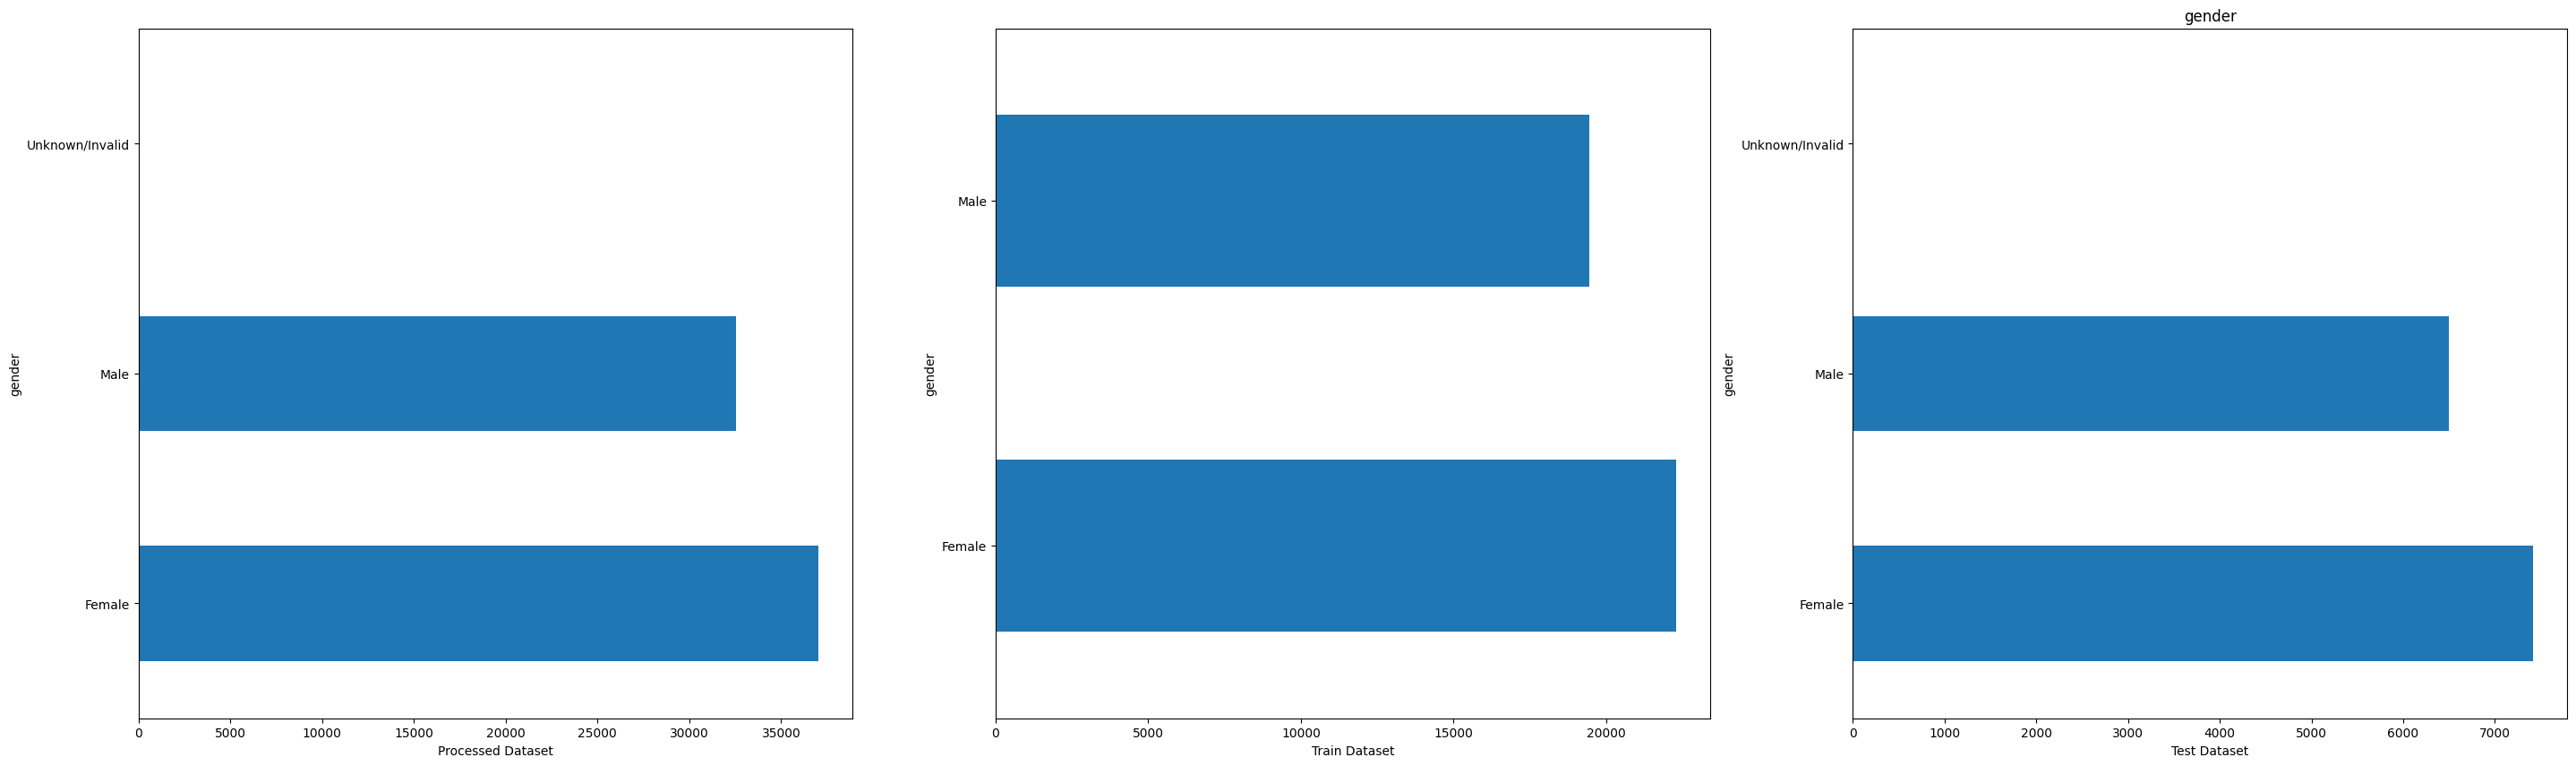

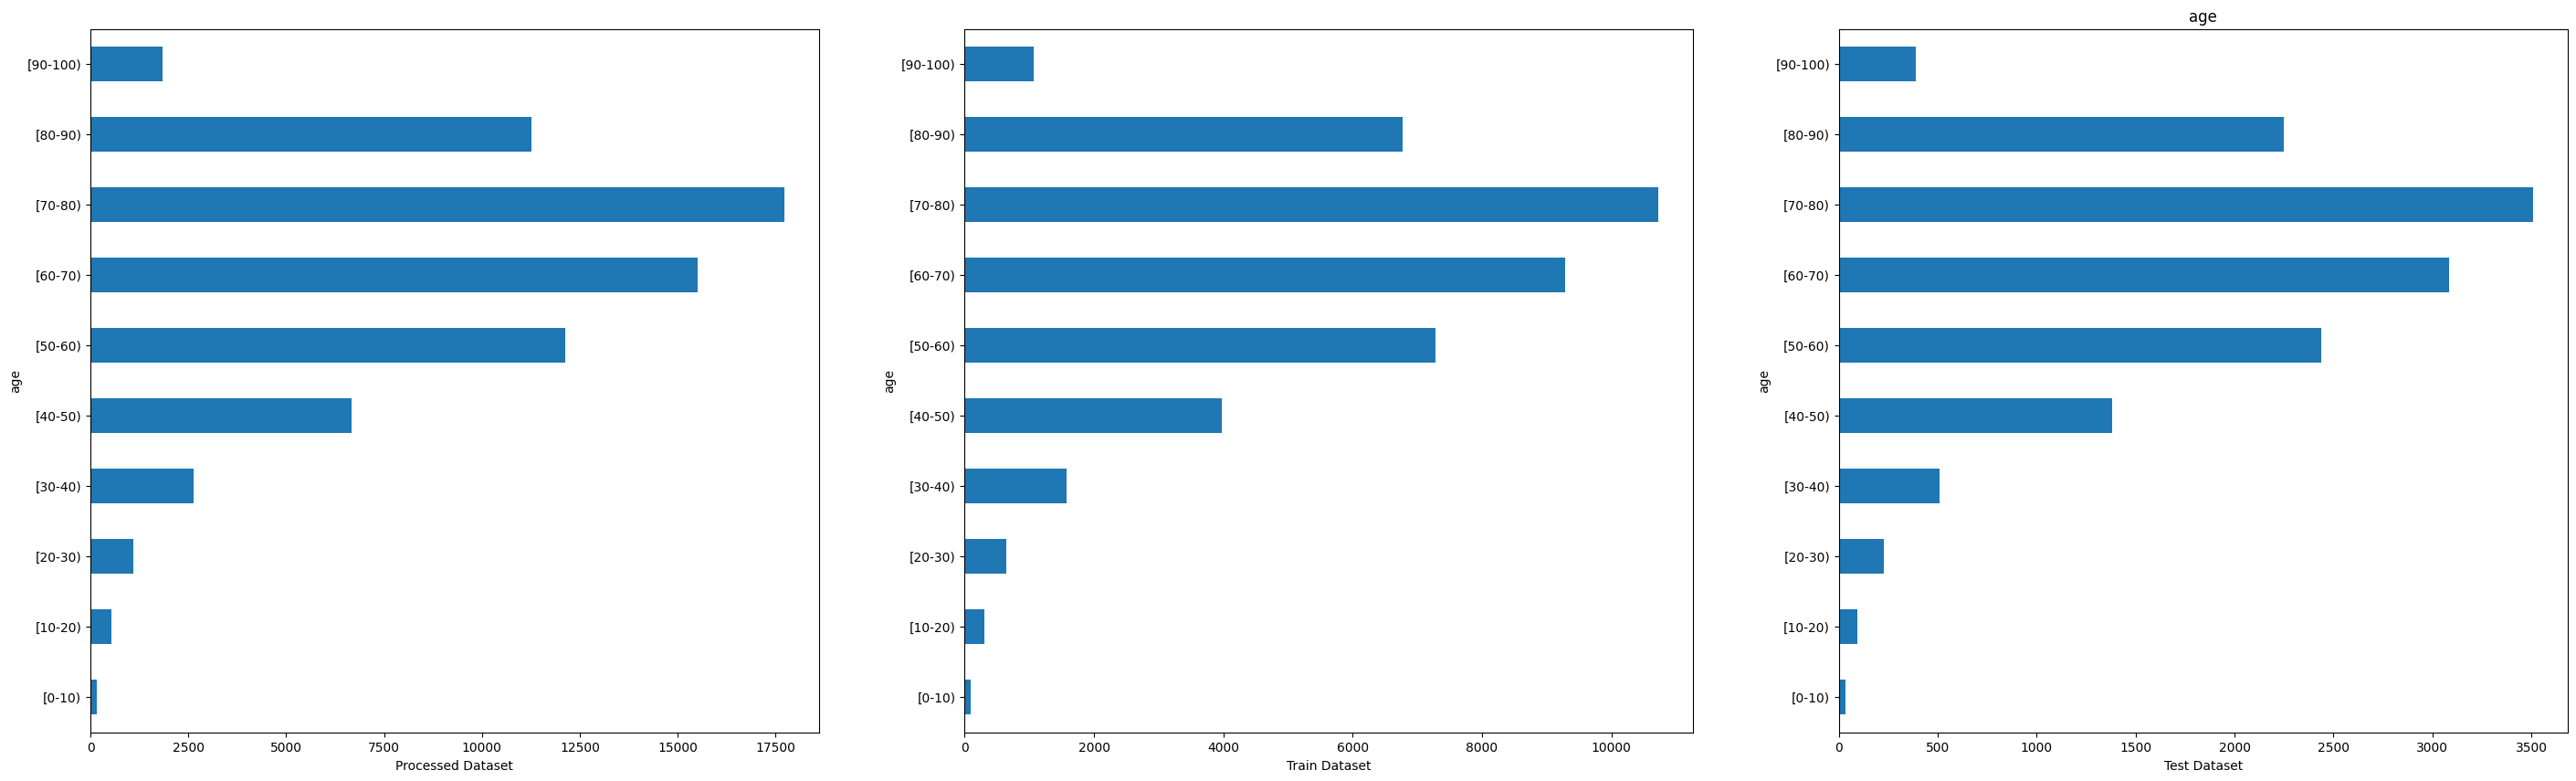

In [60]:
for i in patient_demo_features[:-1]:
    plt.figure(figsize=[35,10])
    plt.subplot(1,3,1)
    show_group_stats_viz(patient_group_analysis_df, i)
    plt.xlabel('Processed Dataset')
    plt.subplot(1,3,2)
    show_group_stats_viz(d_train, i)
    plt.xlabel('Train Dataset')
    plt.subplot(1,3,3)
    show_group_stats_viz(d_test, i)
    plt.xlabel('Test Dataset')
    plt.title(i)

Each partition's Race, Gender, and Age distributions appear similar to those belonging to the full dataset.

### Convert Dataset Splits to TF Dataset

In [61]:
# Convert dataset from Pandas dataframes to TF dataset 
from utils import df_to_dataset
batch_size = 128
diabetes_train_ds = df_to_dataset(d_train, predict_var, batch_size=batch_size)
diabetes_val_ds = df_to_dataset(d_val, predict_var, batch_size=batch_size)
diabetes_test_ds = df_to_dataset(d_test, predict_var, batch_size=batch_size)

In [62]:
# Use sample of the dataset to show transformations later
diabetes_batch = next(iter(diabetes_train_ds))[0]
def demo(feature_column, example_batch):
    feature_layer = layers.DenseFeatures(feature_column)
    print(feature_layer(example_batch))

## Create Categorical Features with TF Feature Columns

### Build Vocabulary for Categorical Features

In order to create the TF categorical features, I had to first create the vocab files with the unique values for a given field that are from the training dataset. The output variable 'vocab_file_list' will be a list of the file paths that can be used in the next step for creating the categorical features.

In [63]:
final_cat_vars 

['race',
 'gender',
 'age',
 'change',
 'readmitted',
 'primary_diagnosis_code',
 'Acarbose',
 'Glimepiride',
 'Glipizide',
 'Glipizide_And_Metformin_Hcl',
 'Glyburide',
 'Glyburide_And_Metformin_Hcl',
 'Insulin_Human',
 'Metformin_Hcl',
 'Miglitol',
 'Nateglinide',
 'Pioglitazone',
 'Pioglitazone_Hcl_And_Glimepiride',
 'Repaglinide',
 'Rosiglitazone_Maleate',
 'Tolazamide',
 'Tolbutamide']

In [65]:
from utils import build_vocab_files
vocab_file_list = build_vocab_files(d_train, final_cat_vars)

In [66]:
vocab_file_list

['./diabetes_vocab/race_vocab.txt',
 './diabetes_vocab/gender_vocab.txt',
 './diabetes_vocab/age_vocab.txt',
 './diabetes_vocab/change_vocab.txt',
 './diabetes_vocab/readmitted_vocab.txt',
 './diabetes_vocab/primary_diagnosis_code_vocab.txt',
 './diabetes_vocab/Acarbose_vocab.txt',
 './diabetes_vocab/Glimepiride_vocab.txt',
 './diabetes_vocab/Glipizide_vocab.txt',
 './diabetes_vocab/Glipizide_And_Metformin_Hcl_vocab.txt',
 './diabetes_vocab/Glyburide_vocab.txt',
 './diabetes_vocab/Glyburide_And_Metformin_Hcl_vocab.txt',
 './diabetes_vocab/Insulin_Human_vocab.txt',
 './diabetes_vocab/Metformin_Hcl_vocab.txt',
 './diabetes_vocab/Miglitol_vocab.txt',
 './diabetes_vocab/Nateglinide_vocab.txt',
 './diabetes_vocab/Pioglitazone_vocab.txt',
 './diabetes_vocab/Pioglitazone_Hcl_And_Glimepiride_vocab.txt',
 './diabetes_vocab/Repaglinide_vocab.txt',
 './diabetes_vocab/Rosiglitazone_Maleate_vocab.txt',
 './diabetes_vocab/Tolazamide_vocab.txt',
 './diabetes_vocab/Tolbutamide_vocab.txt']

### Create Categorical Features with Tensorflow Feature Column API

Using the vocab file list from above that was derived from the selected features earlier, I created categorical features with the Tensorflow Feature Column API

In [67]:
from utils import create_tf_categorical_feature_cols
tf_cat_col_list = create_tf_categorical_feature_cols(final_cat_vars)

INFO:tensorflow:vocabulary_size = 6 in race is inferred from the number of elements in the vocabulary_file ./diabetes_vocab/race_vocab.txt.
INFO:tensorflow:vocabulary_size = 3 in gender is inferred from the number of elements in the vocabulary_file ./diabetes_vocab/gender_vocab.txt.
INFO:tensorflow:vocabulary_size = 11 in age is inferred from the number of elements in the vocabulary_file ./diabetes_vocab/age_vocab.txt.
INFO:tensorflow:vocabulary_size = 3 in change is inferred from the number of elements in the vocabulary_file ./diabetes_vocab/change_vocab.txt.
INFO:tensorflow:vocabulary_size = 4 in readmitted is inferred from the number of elements in the vocabulary_file ./diabetes_vocab/readmitted_vocab.txt.
INFO:tensorflow:vocabulary_size = 637 in primary_diagnosis_code is inferred from the number of elements in the vocabulary_file ./diabetes_vocab/primary_diagnosis_code_vocab.txt.
For the column Primary_Diagnosis_Code used column embedding of Dimension 10
INFO:tensorflow:vocabulary_

In [68]:
# Sample
test_cat_var1 = tf_cat_col_list[2]
print("Example categorical field:\n{}".format(test_cat_var1))
demo(test_cat_var1, diabetes_batch)

Example categorical field:
IndicatorColumn(categorical_column=VocabularyFileCategoricalColumn(key='age', vocabulary_file='./diabetes_vocab/age_vocab.txt', vocabulary_size=11, num_oov_buckets=1, dtype=tf.string, default_value=-1, file_format=None))
tf.Tensor(
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]], shape=(128, 12), dtype=float32)


## Create Numerical Features with TF Feature Columns

Creating normalized Tensorflow numeric features for the model using z-score normalizer function

In [69]:
from utils import create_tf_numerical_feature_cols
tf_cont_col_list = create_tf_numerical_feature_cols(final_nums_vars, d_train)

In [70]:
test_cont_var1 = tf_cont_col_list[0]
print("Example continuous field:\n{}\n".format(test_cont_var1))
demo(test_cont_var1, diabetes_batch)

Example continuous field:
NumericColumn(key='num_lab_procedures', shape=(1,), default_value=(0,), dtype=tf.float64, normalizer_fn=<function create_tf_numeric_feature.<locals>.<lambda> at 0x00000178291AB8B8>)

tf.Tensor(
[[-2.2105262 ]
 [-2.2105262 ]
 [-0.15789473]
 [ 1.1052631 ]
 [-0.2631579 ]
 [-1.5789474 ]
 [ 0.10526316]
 [ 0.7368421 ]
 [ 1.2631578 ]
 [-0.15789473]
 [-0.68421054]
 [-0.42105263]
 [ 0.2631579 ]
 [ 1.6842105 ]
 [-1.3684211 ]
 [ 0.31578946]
 [-0.31578946]
 [ 1.        ]
 [-0.15789473]
 [ 0.47368422]
 [-1.7368422 ]
 [-0.42105263]
 [ 0.        ]
 [ 0.68421054]
 [-1.7894737 ]
 [-0.94736844]
 [-1.1052631 ]
 [-0.05263158]
 [ 1.4736842 ]
 [ 0.31578946]
 [ 0.36842105]
 [-0.42105263]
 [-0.10526316]
 [ 1.4210526 ]
 [ 1.5263158 ]
 [-0.47368422]
 [ 0.7894737 ]
 [-0.36842105]
 [ 0.31578946]
 [-0.47368422]
 [-0.2631579 ]
 [ 0.        ]
 [ 0.6315789 ]
 [ 0.47368422]
 [ 0.7368421 ]
 [-0.10526316]
 [-1.5789474 ]
 [ 0.2631579 ]
 [ 1.2631578 ]
 [-0.2631579 ]
 [ 0.5263158 ]
 [ 0.05263158]


## Build Deep Learning Regression Model with Sequential API and TF Probability Layers

### Use DenseFeatures to combine features for model


Creating a new input layer called 'claim_feature_layer' by combining TF categorical and numerical variables


In [71]:
claim_feature_columns = tf_cat_col_list + tf_cont_col_list
claim_feature_layer = tf.keras.layers.DenseFeatures(claim_feature_columns)

In [72]:
claim_feature_columns

[IndicatorColumn(categorical_column=VocabularyFileCategoricalColumn(key='race', vocabulary_file='./diabetes_vocab/race_vocab.txt', vocabulary_size=6, num_oov_buckets=1, dtype=tf.string, default_value=-1, file_format=None)),
 IndicatorColumn(categorical_column=VocabularyFileCategoricalColumn(key='gender', vocabulary_file='./diabetes_vocab/gender_vocab.txt', vocabulary_size=3, num_oov_buckets=1, dtype=tf.string, default_value=-1, file_format=None)),
 IndicatorColumn(categorical_column=VocabularyFileCategoricalColumn(key='age', vocabulary_file='./diabetes_vocab/age_vocab.txt', vocabulary_size=11, num_oov_buckets=1, dtype=tf.string, default_value=-1, file_format=None)),
 IndicatorColumn(categorical_column=VocabularyFileCategoricalColumn(key='change', vocabulary_file='./diabetes_vocab/change_vocab.txt', vocabulary_size=3, num_oov_buckets=1, dtype=tf.string, default_value=-1, file_format=None)),
 IndicatorColumn(categorical_column=VocabularyFileCategoricalColumn(key='readmitted', vocabulary_

### Build Sequential API Model from DenseFeatures and TF Probability Layers


Building a model that connects the Sequential API, DenseFeatures, and Tensorflow Probability layers into a deep learning model. 

While arranging this file for Github, I am putting the hyper parameter optimization code first. My actual process: Run a sequential mode, hyperparameter optimization and finally running the sequential model with the new parameters.

In [75]:
# Ignore Tensorflow Warnings
import logging
logging.getLogger('tensorflow').disabled = True

__I am using the hyperopt library to find the best hyperparameters for my model.__

In [73]:
from utils import posterior_mean_field, prior_trainable
import hyperopt
#import cloudpickle as pickle
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.losses import MeanSquaredError, MeanAbsoluteError
from tensorflow.keras.metrics import Mean
from tensorflow.keras.models import Sequential
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials

tfd = tfp.distributions
tfpl = tfp.layers
tfk = tf.keras

feature_layer = claim_feature_layer

# Actual Model

def build_sequential_model(feature_layer, params):
    model = Sequential([
        feature_layer,
        Dense(params['units'], activation='relu'),
        Dropout(params['dropout']),
        Dense(params['units'], activation='relu'),
        Dropout(params['dropout']),
        Dense(params['units']//2, activation='relu'),
        tfp.layers.DenseVariational(1+1, posterior_mean_field, prior_trainable),
        #DenseVariationalSerializable(1+1, posterior_mean_field, prior_trainable),
        tfp.layers.DistributionLambda(
            lambda t:tfp.distributions.Normal(
                loc=t[..., :1],
                scale=1e-3 + tf.math.softplus(0.01 * t[...,1:])
            )
        )
    ])
    return model

def build_diabetes_model(train_ds, val_ds, feature_layer, params):
    model = build_sequential_model(feature_layer, params)
    optimizer = params['optimizer']
    if optimizer == 'adam':
        #optimizer = Adam(learning_rate=params['lr'])
        optimizer = Adam()
    elif optimizer == 'sgd':
        #optimizer = SGD(learning_rate=params['lr'])
        optimizer = SGD()
    elif optimizer == 'rmsprop':
        #optimizer = RMSprop(learning_rate=params['lr'])
        optimizer = RMSprop()
        
    loss_metric = params['loss_metric']
    if loss_metric == 'mse':
        loss_metric = MeanSquaredError()
    elif loss_metric == 'mae':
        loss_metric = MeanAbsoluteError()
        
        
    model.compile(optimizer=optimizer, loss=loss_metric, metrics=[loss_metric])
    early_stop = EarlyStopping(monitor='val_loss', patience=125)
    history = model.fit(train_ds, validation_data=val_ds,
                        callbacks=[early_stop],
                        epochs=params['epochs'],
                        verbose=0)
    loss = history.history['val_loss'][-1]
    return {'loss': loss, 'status': STATUS_OK, 'model': model, 'early_stop': early_stop}

# Define the search space
space = {
    'units': hp.choice('units', [32,64,128]),
    'dropout': hp.uniform('dropout', 0.3, 0.5),
    'optimizer': hp.choice('optimizer', ['adam', 'rmsprop','sgd']),
    #'lr': hp.loguniform('lr', -3, -1),
    'loss_metric': hp.choice('loss_metric', ['mse', 'mae']),
    'epochs': hp.choice('epochs', [1000, 2000, 3000])}

# Define the objective function
def objective(params):
    result = build_diabetes_model(diabetes_train_ds, diabetes_val_ds, feature_layer, params)
    return result

# Run the hyperparameter search
trials = Trials()
best = fmin(objective, space, algo=tpe.suggest, max_evals=50, trials=trials)
print('Best hyperparameters:', best)

# Retrieve the best model
best_trial = trials.best_trial
best_model = best_trial['result']['model']

100%|██████████| 50/50 [10:06:57<00:00, 728.35s/trial, best loss: 2.0406911373138428] 
Best hyperparameters: {'dropout': 0.3559514563048156, 'epochs': 0, 'loss_metric': 1, 'optimizer': 0, 'units': 0}


The best hyperparameters were: </br>
Epochs - 1000 - All the epochs have almost same effect, as the early stop is triggered in each option, way before the 1000 epochs. </br>
loss_metric: 'mae'  -  Makes sense as we have a lot of outliers and mse is sensitive to outliers. </br>
Optimizer - 'adam'</br>
Units = 32</br>
Dropout = 0.35

__Why Probabilistic output?__  </br>[Used CHATGPT for better explanation]

In traditional deep learning, model parameters are typically learned by optimizing a loss function with respect to a single point estimate of the model parameters i.e the model's parameters are determined by finding the set of parameter values that minimize the loss function over the training data.

In contrast, a Bayesian neural network with probabilistic output allows us to learn the posterior distribution over the model parameters instead of just a single point estimate. This means that we can infer a distribution of likely values for each model parameter, rather than just a single best value. This distribution can be used to estimate the uncertainty in the model's predictions.

The tfp.layers.DenseVariational and tfp.layers.DistributionLambda layers in the given TensorFlow code are part of the TensorFlow Probability library and are used to construct a Bayesian neural network with a normal distribution output. Here's an explanation of each of these steps:

tfp.layers.DenseVariational(1+1, posterior_mean_field, prior_trainable): This layer defines a dense neural network layer with variational inference. The 1+1 argument specifies the number of output units, with the first unit representing the mean of the normal distribution output and the second unit representing the standard deviation of the normal distribution output. 

tfp.layers.DistributionLambda(lambda t:tfp.distributions.Normal(loc=t[..., :1], scale=1e-3 + tf.math.softplus(0.01 * t[...,1:]))): This layer transforms the output of the previous DenseVariational layer into a normal distribution with mean and standard deviation given by the output of the previous layer's two units. The lambda function specifies the transformation, which takes the output tensor t and applies a normal distribution with mean equal to the first output unit t[..., :1] and standard deviation equal to 1e-3 + tf.math.softplus(0.01 * t[...,1:]). The softplus function is used to ensure that the standard deviation is always positive.

__Overall, these two layers are used to add a probabilistic interpretation to the output of the neural network, allowing for uncertainty in the model's predictions. The model can be trained using Bayesian methods to learn the posterior distribution over the model parameters, rather than just a single point estimate.__

__Final Model__

In [118]:
from utils import posterior_mean_field, prior_trainable
def build_sequential_model(feature_layer):
    model = tf.keras.Sequential([
        feature_layer,
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dropout(0.35),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dropout(0.35),
        tf.keras.layers.Dense(16, activation='relu'),
        tfp.layers.DenseVariational(1+1, posterior_mean_field, prior_trainable),
        tfp.layers.DistributionLambda(
            lambda t:tfp.distributions.Normal(loc=t[..., :1],
                                             scale=1e-3 + tf.math.softplus(0.01 * t[...,1:])
                                             )
        ),
    ])
    return model

def build_diabetes_model(train_ds, val_ds,  feature_layer,  epochs=500, loss_metric='mse'):
    model = build_sequential_model(feature_layer)
    model.compile(optimizer = 'adam', loss=loss_metric, metrics=[loss_metric])
    early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=30)     
    history = model.fit(train_ds, validation_data=val_ds,
                        callbacks=[early_stop],
                        epochs=epochs)
    return model, history 

In [78]:
num_epoch = 2000
diabetes_model, history = build_diabetes_model(diabetes_train_ds, diabetes_val_ds,  claim_feature_layer,  epochs=num_epoch)

Epoch 1/2000
327/327 [==============================] - 7s 10ms/step - loss: 26.0396 - mse: 25.8214 - val_loss: 18.9641 - val_mse: 18.4252
Epoch 2/2000
327/327 [==============================] - 3s 7ms/step - loss: 16.1725 - mse: 15.4628 - val_loss: 14.0172 - val_mse: 13.2141
Epoch 3/2000
327/327 [==============================] - 3s 7ms/step - loss: 13.0687 - mse: 12.2561 - val_loss: 11.3008 - val_mse: 10.0839
Epoch 4/2000
327/327 [==============================] - 3s 7ms/step - loss: 12.1871 - mse: 11.3262 - val_loss: 10.1895 - val_mse: 9.3292
Epoch 5/2000
327/327 [==============================] - 3s 7ms/step - loss: 10.6329 - mse: 9.7049 - val_loss: 11.0075 - val_mse: 10.2026
Epoch 6/2000
327/327 [==============================] - 3s 7ms/step - loss: 10.3910 - mse: 9.6188 - val_loss: 9.5626 - val_mse: 8.6846
Epoch 7/2000
327/327 [==============================] - 3s 7ms/step - loss: 9.3552 - mse: 8.6135 - val_loss: 8.9538 - val_mse: 8.3683
Epoch 8/2000
327/327 [====================

In [78]:
# Best Model
best_model.summary()

Model: "sequential_32"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_features_2 (DenseFeat  multiple                 6380      
 ures)                                                           
                                                                 
 dense_99 (Dense)            multiple                  4064      
                                                                 
 dropout_66 (Dropout)        multiple                  0         
                                                                 
 dense_100 (Dense)           multiple                  1056      
                                                                 
 dropout_67 (Dropout)        multiple                  0         
                                                                 
 dense_101 (Dense)           multiple                  1056      
                                                     

Plotting Loss Curves

In [79]:
def plot_history(history):

    fig, m_axs = plt.subplots(1,2, figsize = (12, 4))
    m_axs[0].plot(history.history['loss'], label = "Training Loss")
    m_axs[0].plot(history.history['val_loss'], label = "Validation Loss")
    m_axs[0].set(xlabel='Epoch', ylabel='Loss')
    m_axs[0].set_yscale('log')
    m_axs[0].legend()
    m_axs[0].set_title('Training Loss vs Validation Loss');
    
    m_axs[1].plot(history.history['mse'], label = "Training MSE")
    m_axs[1].plot(history.history['val_mse'], label = "Validation MSE")
    m_axs[1].set(xlabel='Epoch', ylabel='MSE')
    m_axs[1].legend()
    m_axs[1].set_title('Training MSE vs Validation MSE')

I had tried with mse and mae loss for diff experiments.  Showing both plots

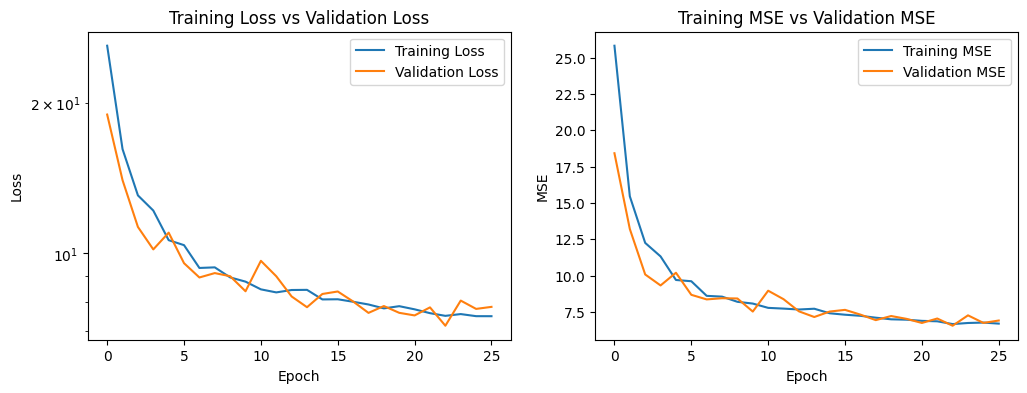

In [80]:
plot_history(history)

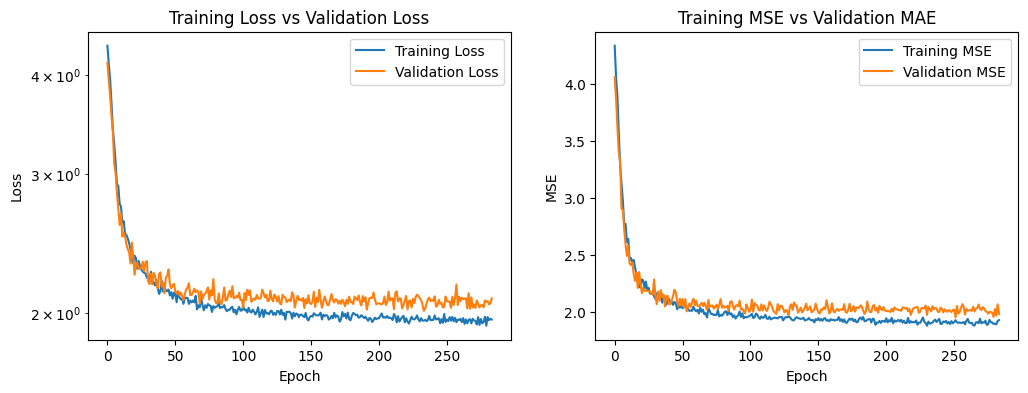

### Show Model Uncertainty Range with TF Probability

Now that I have trained a model with TF Probability layers, I can extract the mean and standard deviation for each prediction. 

In [81]:
feature_list = final_cat_vars + final_nums_vars
diabetes_x_tst = dict(d_test[feature_list])
diabetes_yhat = diabetes_model(diabetes_x_tst)
preds = diabetes_model.predict(diabetes_test_ds)

from utils import get_mean_std_from_preds
m, s = get_mean_std_from_preds(diabetes_yhat)

109/109 [==============================] - 2s 4ms/step


### Prediction Output

In [83]:
prob_outputs = {
    "pred": preds.flatten(),
    "actual_value": d_test['time_in_hospital'].values,
    "pred_mean": m.numpy().flatten(),
    "pred_std": s.numpy().flatten()
}
prob_output_df = pd.DataFrame(prob_outputs)

In [84]:
prob_output_df.head()

,pred,actual_value,pred_mean,pred_std
0,3.724705,2.0,1.667241,0.690575
1,3.349564,2.0,3.775111,0.690616
2,6.872179,12.0,5.897294,0.692054
3,4.729957,8.0,4.854263,0.690809
4,4.271566,1.0,1.790161,0.690201


### Convert Regression Output to Classification Output for Patient Selection

The final goal is to predict if the patient stays for 5-7 days or lower. Hence, the output required is more of a classification than a regression problem. </br>
 
So, I need to convert the predictions to a binary label for whether the patient meets the time criteria. (1 if stay >= 5 days, else 0)

In [85]:
from utils import get_student_binary_prediction
student_binary_prediction = get_student_binary_prediction(prob_output_df, 'pred_mean')

#### Add Binary Prediction to Test Dataframe

Adding the student_binary_prediction output to a dataframe to better visualize and also to prepare the data for the Aequitas toolkit. The Aequitas toolkit requires that the predictions be mapped to a binary label for the predictions (called 'score' field) and the actual value (called 'label_value').

In [86]:
def add_pred_to_test(test_df, pred_np, demo_col_list):
    for c in demo_col_list:
        test_df[c] = test_df[c].astype(str)
    test_df['score'] = pred_np
    test_df['label_value'] = test_df['time_in_hospital'].apply(lambda x: 1 if x >=5 else 0)
    return test_df

pred_test_df = add_pred_to_test(d_test, student_binary_prediction, ['race', 'gender'])

In [87]:
pred_test_df[['patient_nbr', 'gender', 'race', 'time_in_hospital', 'score', 'label_value']].head()

,patient_nbr,gender,race,time_in_hospital,score,label_value
1,378,Female,Caucasian,2.0,0,0
7,1314,Female,Caucasian,2.0,0,0
9,2025,Female,Caucasian,12.0,1,1
10,3069,Male,Caucasian,8.0,0,1
17,6696,Male,AfricanAmerican,1.0,0,0


### Model Evaluation Metrics

Using common classification metrics

In [99]:
from sklearn.metrics import classification_report, roc_auc_score
y_true = pred_test_df['label_value'].values 
y_pred = pred_test_df['score'].values

In [100]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.79      0.88      0.83      8867
           1       0.73      0.58      0.65      5045

    accuracy                           0.77     13912
   macro avg       0.76      0.73      0.74     13912
weighted avg       0.77      0.77      0.77     13912



In [101]:
roc_auc_score(y_true, y_pred)

0.7314516257930348

Precision: Of all the instances that the model predicted as belonging to class 1, 73% of them actually belonged to class 1. In other words, when the model predicted that a patient will stay more than 5 days, it was correct 73% of the time.

Recall: Of all the instances that actually belong to class 1, the model correctly identified 58% of them as belonging to class 1. In other words, when a patient actually stays more than 5 days, the model correctly identified them as having diabetes 58% of the time.

F1-score: The F1-score is the harmonic mean of precision and recall. It takes into account both precision and recall, providing a single score that balances both metrics. For class 1, the F1-score is 0.65, which indicates a moderately good balance between precision and recall.

Support: The number of instances in the test set that belong to class 1 is 5045.

### Discussion

Since the goal of this project is to build a predictive model that can identify which type of patients the company should focus their efforts testing this drug on, I think it would be better if the model has a higher precision so we have more confidence in a positive result when predicting patients who are likely to be hospitalized at least 5 days to control the costs of this clinical trial. </br>

This will prevent incurring additional costs for administering this drug to the patient and monitoring as oppose to a higher recall model which could potentially predict a negative case as positive.

__What are some areas of improvement for future iterations?__

To improve this further,

- Collecting more data to increase the size of the dataset, which can help the model to better capture the patterns in the data.

- Experimenting with different classification algorithms and hyperparameters to find the best model for the given problem.

- Trying to procure better computational resources for trying more complex models and hyperparameter optimizations

- Addressing the class imbalance in the dataset by using techniques such as oversampling or undersampling.

- Performing additional feature engineering like for 'primary_diagnosis_code' and 'other_diagnosis_codes' to reduce cardinality and include them during training.

- Ensembling multiple models to combine their predictions and improve overall performance.

- Instead of selecting only the first encounter, we can considerusing an aggregated encounter data and use it during training.

## Evaluating Potential Model Biases with Aequitas Toolkit

Aequitas is a toolkit developed by DSSG (Data Science for Social Good) that provides a set of metrics and algorithms to detect and mitigate bias in machine learning models. The goal of Aequitas is to help data scientists, researchers, and policymakers ensure that their models are fair and equitable, and to promote transparency and accountability in the machine learning pipeline.

Aequitas can be used to evaluate bias in models across different subgroups, such as gender or race, and to explore how different thresholds affect the balance of false positives and false negatives. It also provides a set of visualization tools to help understand the impact of different features on model performance across different subgroups.

### Prepare Data For Aequitas Bias Toolkit

Using the gender and race fields, we will prepare the data for the Aequitas Toolkit.

In [91]:
# Aequitas
from aequitas.preprocessing import preprocess_input_df
from aequitas.group import Group
from aequitas.plotting import Plot
from aequitas.bias import Bias
from aequitas.fairness import Fairness

ae_subset_df = pred_test_df[['race', 'gender', 'score', 'label_value']]
ae_df, _ = preprocess_input_df(ae_subset_df)
g = Group()
xtab, _ = g.get_crosstabs(ae_df)
absolute_metrics = g.list_absolute_metrics(xtab)
clean_xtab = xtab.fillna(-1)
aqp = Plot()
b = Bias()

### Reference Group Selection

In Aequitas, the reference group is the group that is used as a baseline to compare the other groups against.


In [92]:
# test reference group with Caucasian Male
bdf = b.get_disparity_predefined_groups(clean_xtab, 
                    original_df=ae_df, 
                    ref_groups_dict={'race':'Caucasian', 'gender':'Male'
                                     }, 
                    alpha=0.05, 
                    check_significance=False)


f = Fairness()
fdf = f.get_group_value_fairness(bdf)

get_disparity_predefined_group()


### Race and Gender Bias Analysis for Patient Selection

True Positive Rate (TPR) Disparity </br>

TPR disparity measures how often a model correctly predicts the positive outcome for each group, and whether this varies between different groups based on their characteristics such as race, gender, or age.

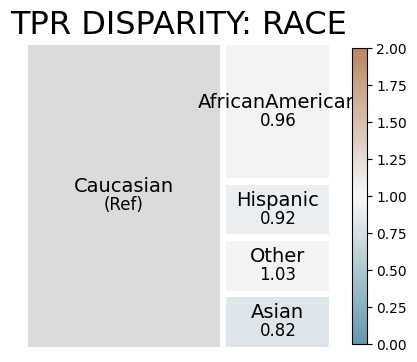

In [93]:
tpr_disparity_race = aqp.plot_disparity(bdf, group_metric='tpr_disparity', 
                                       attribute_name='race')

__The values for classes other than ref (i.e., non-reference groups) indicate the ratio of their TPR to that of the reference group.__</br>

For example, a __value of 0.96__ for a non-reference group means that the TPR for that group is 0.96 times that of the reference group, indicating a __slight TPR disparity__. Similarly, a __value of 1.03__ for a non-reference group means that the TPR for that group is 1.03 times that of the reference group, indicating a __slight advantage for that group__. 

In [106]:
ae_df['race'].value_counts()

Caucasian          10648
AfricanAmerican     2656
Hispanic             291
Other                224
Asian                 93
Name: race, dtype: int64

The model does have some TPR disparity for Asian patients. But it can be explained by the table above showing Asian population is a very very small part of the dataset.

For other races, there isnt a significant disparity 

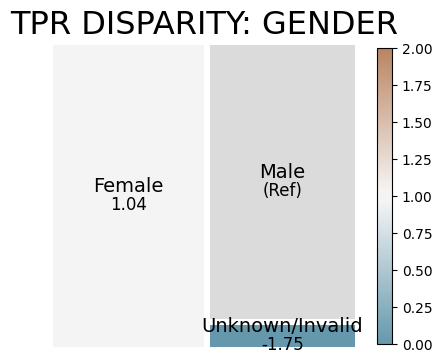

In [94]:
tpr_disparity_gender = aqp.plot_disparity(bdf, group_metric='tpr_disparity', 
                                       attribute_name='gender')

In [108]:
ae_df['gender'].value_counts()

Female             7416
Male               6495
Unknown/Invalid       1
Name: gender, dtype: int64

There isnt a significant disparity between Male and Female Patients.

False Positive Rate (FPR) Disparity 

FPR disparity can help identify if the model is making more false positive errors for a particular group compared to another group. This is important to ensure fairness in the model's predictions across different groups.

fpr > 1 group is experiencing more false positives than the reference group. </br>
fpr <1 - group is experiencing fewer false positives than the reference group.

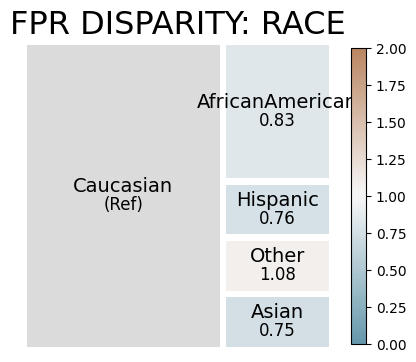

In [95]:
fpr_disparity_race = aqp.plot_disparity(bdf, group_metric='fpr_disparity', 
                                       attribute_name='race')

It seems Caucasian Population has a significantly higher false positive rate than African American, Hispanic and Asian Populations

The 224 patients of the "Other" category have a slight higher rate of False Positives

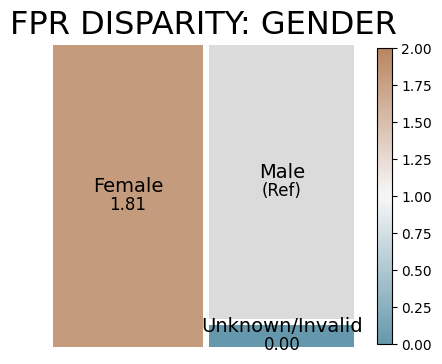

In [114]:
fpr_disparity_gender = aqp.plot_disparity(bdf, group_metric='fpr_disparity', 
                                       attribute_name='gender')

FPR for Females is 1.81 times of Male patients. This is a significant difference and could be an indication of bias or unfairness in the model.

Since the population sizes are comparable, some features in the model could be the reason behindn this disparity. Feature analysis along with clinical advice is necessary.

### Fairness Analysis Example - Relative to a Reference Group

Earlier I defined our reference group and then calculated disparity metrics relative to this grouping. 

Now I will visualize the actual metrics for the reference group as well and analyze whether there is disparity.

Absolute Value Fairness Determination </br>
Red = False/Not Fair </br>
Green = True/Fair </br>

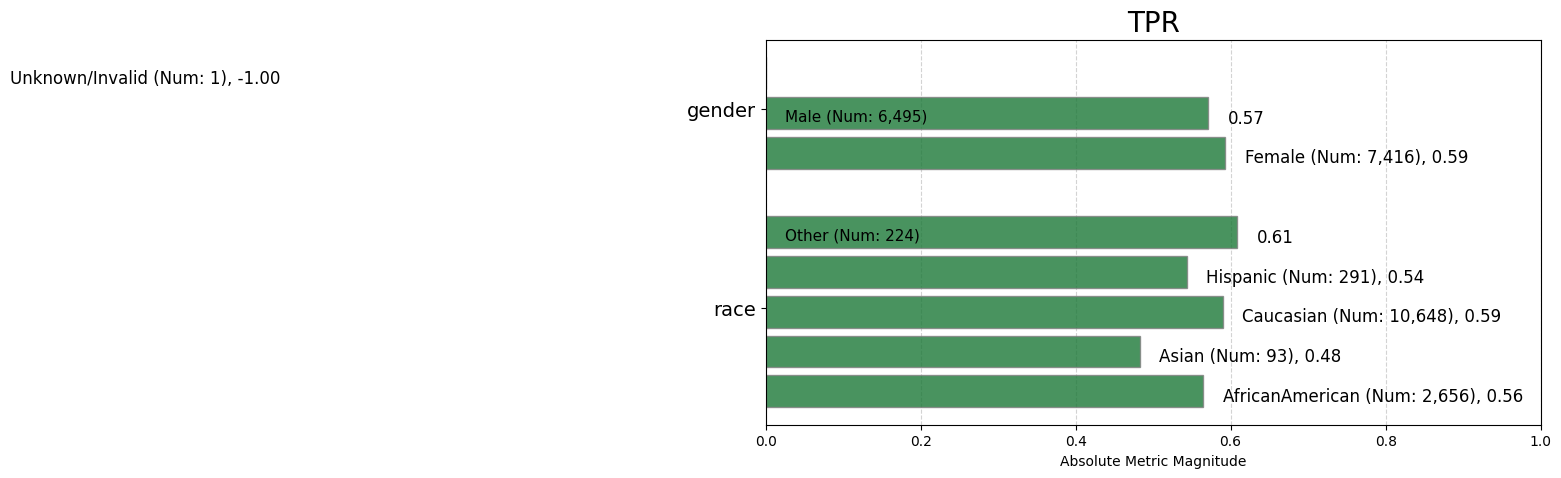

In [96]:
tpr_fairness = aqp.plot_fairness_group(fdf, group_metric='tpr', title=True)

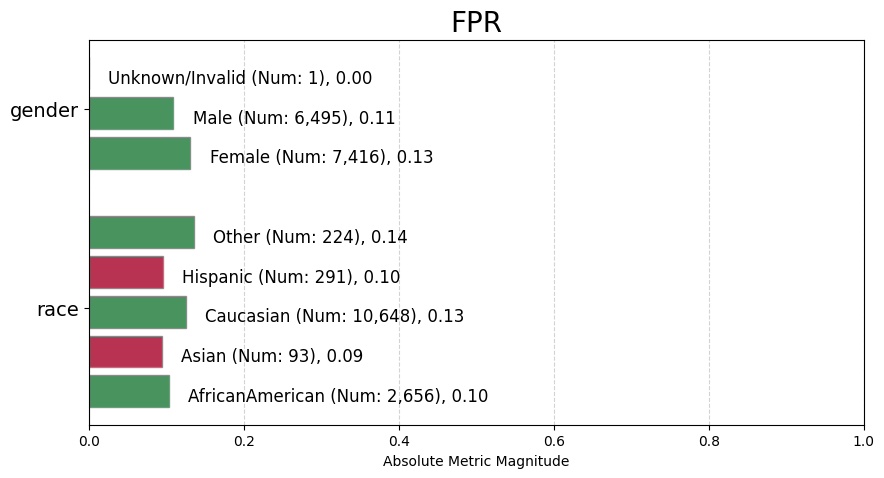

In [97]:
fpr_fairness = aqp.plot_fairness_group(fdf, group_metric='fpr', title=True)